In [3]:
import torch # version 1.3.1
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torch.nn.functional as F

import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F

import os
from os import listdir
from glob import glob
from datetime import datetime

import cv2

import matplotlib.pylab as plt

# data augmentation
from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter

# Split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

# remove if not needed because augmentation is already applied 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

import re

import random

import time
import copy

# INSTALL tqdm for jupyter lab:
# 1. pip install tqdm==4.36.1
# 2. pip install ipywidgets
# 3. jupyter nbextension enable --py widgetsnbextension
# 4. jupyter labextension install @jupyter-widgets/jupyterlab-manager (installed nodejs and npm needed)
from tqdm import tqdm_notebook as tqdm

#visualization at the end:
#from bokeh.plotting import figure
#from bokeh.io import show
#from bokeh.models import LinearAxis, Range1d

import pandas as pd

import numpy as np

import seaborn as sns
sns.set()

In [4]:
loaded_train_df = pd.read_json("dataframes/final_train_df.json")
loaded_val_df = pd.read_json("dataframes/val_df.json")
loaded_test_df = pd.read_json("dataframes/test_df.json")

In [6]:
OUTPUT_PATH = "saved_models/model_version_"
MODEL_EVAL_PATH = "saved_models/model_eval_"

In [122]:
image_datasets = {"train": train_dataset, "val": val_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val", "test"]}

In [7]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
#transforms to apply to our data:
def my_transform(key="train_transform"):
    #boost class 1 in training set:
    train_transform = [transforms.Resize((50, 50)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(90), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.7718, 0.6068, 0.7322],std=[0.0926, 0.1417, 0.1081])]
    #change values:
    val_transform = [transforms.Resize((50, 50)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.8031, 0.6202, 0.7270],std=[0.0938, 0.1420, 0.1049])]
    
    test_transform = [transforms.Resize((50, 50)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.8208, 0.6423, 0.7406],std=[0.0892, 0.1410, 0.1037])]
        
    data_transforms = {'train_transform': transforms.Compose(train_transform),
                       'val_transform': transforms.Compose(val_transform),
                       'test_transform': transforms.Compose(test_transform)}
    return data_transforms[key]

In [10]:
class BreastCancerDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.states = df
        self.transform=transform
      
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.image_path.values[idx] 
        image = Image.open(image_path)
        image = image.convert('RGB') # try to convert to YUV instead of RGB later
        
        if self.transform:
            image = self.transform(image)
         
        label = np.int(self.states.label.values[idx])
        return {"image": image,
                "label": label,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}

In [11]:
train_dataset = BreastCancerDataset(loaded_train_df, transform=my_transform(key="train_transform"))
val_dataset = BreastCancerDataset(loaded_val_df, transform=my_transform(key="val_transform"))
test_dataset = BreastCancerDataset(loaded_test_df, transform=my_transform(key="test_transform"))

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [13]:
dataloaders = {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}

In [14]:
class ThreeLayerCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(ThreeLayerCNN, self).__init__()
        
        # Conv Layer 1
        self.convLayer1 = nn.Sequential( # TODO: calculate stride, padding
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=8, stride=1),
            nn.BatchNorm2d(16), #NEU
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))
        
        # Conv Layer 2
        self.convLayer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=8, stride=1),
            nn.BatchNorm2d(32), #NEU
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))
            
        # Dropout: avoid overfitting. only for training
        self.drop_out = nn.Dropout()        
        
        #Fully Connected Layer
      #  self.fc1 = nn.Linear(128, 2) #      32, 34, 34 
        self.fc1 = nn.Linear(32*34*34, 128)
       # self.fc1 = nn.Linear(32*1*1, 128) # 32,1,1
        self.fc2 = nn.Linear(128, 2)
    
    
    def forward(self, x):
        out = self.convLayer1(x)
        #print("after conv1: " + str(out.shape))
        out = self.convLayer2(out)
        #print("after conv2: " + str(out.shape)) # after conv2: torch.Size([32, 32, 34, 34])
        # what does reshape do? -> flatten. why befor drop_out?
       # out = out.reshape(out.size(0), -1) 
       # out = out.view(-1, 128)
        out = out.view(-1, 32*34*34)
       # out = out.view(-1, 32*1*1)
        out = self.drop_out(out)
        #print("after dropout: " + str(out.shape))
        out = self.fc1(out)
        #print("after fc1: " + str(out.shape))
        out = self.fc2(out)
        #print("after fc2: " + str(out.shape))
        
        return out

In [15]:
model = ThreeLayerCNN().to(device)

In [17]:
#JUST FOR NOW:
curr_model_output_path = "saved_models/model_version_2020_1_11_22:12:11/model_version_2020_1_11_22:12:11.pth"

#test with current model:
model_to_test = ThreeLayerCNN()
model_to_test.load_state_dict(torch.load(curr_model_output_path))

<All keys matched successfully>

In [33]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

In [121]:
def evaluateModel(model, predictions_df, key):
    
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloaders[key]):
            inputs = data["image"].to(device)
            labels = data["label"].to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            proba = outputs.cpu().numpy().astype(np.float)        
            
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "true"] = data["label"].numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "predicted"] = preds.cpu().numpy().astype(np.int)
            # probability for class 1
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "proba"] = sigmoid(proba[:, 1])
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "x"] = data["x"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "y"] = data["y"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "patient_id"] = data["patient_id"].numpy().astype(int)
            
    predictions_df = predictions_df.dropna()
    return predictions_df

In [122]:
image_datasets = {"train": train_dataset, "val": val_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val", "test"]}

In [124]:
test_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["test"]), columns = ["true", "predicted", "proba"])

test_predictions = evaluateModel(model_to_test, test_predictions, "test")

0
63
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1])
softmax: [0.01045718 0.01452513 0.0972483  0.00222867 0.00670364 0.00613112
 0.0011167  0.08665756 0.00307092 0.00961096 0.00486878 0.02392687
 0.0030159  0.00079818 0.0101416  0.01372494 0.04752126 0.00183497
 0.02842671 0.0070387  0.0010085  0.00092097 0.01206733 0.00055757
 0.00323594 0.00797459 0.00303859 0.02028963 0.03337584 0.00405466
 0.0053226  0.01296596 0.03655408 0.02998621 0.00326406 0.01193724
 0.00033685 0.00425083 0.00205096 0.00213007 0.03457461 0.00462476
 0.07321449 0.00336697 0.00239594 0.00733309 0.00499552 0.0003814

320
383
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1])
softmax: [0.00301122 0.00818193 0.01116566 0.00159048 0.00687027 0.00405193
 0.00224427 0.00350238 0.00407163 0.00836468 0.00541132 0.00209579
 0.00355383 0.00400903 0.00489017 0.01308466 0.00169439 0.00655463
 0.00111923 0.00446852 0.07531943 0.01270594 0.00717813 0.01030926
 0.02973752 0.01639791 0.0129991  0.04113038 0.00877405 0.01301874
 0.01171797 0.0217124  0.02245781 0.02629093 0.01525168 0.01229458
 0.02955422 0.01080409 0.01373008 0.01286347 0.01500092 0.01586672
 0.03259887 0.01888542 0.00935245 0.0234778  0.01350941 0.0158

640
703
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
softmax: [0.0109452  0.0089262  0.02091238 0.01251956 0.01797256 0.00671767
 0.02855942 0.0093587  0.01368592 0.0272587  0.01551409 0.01342507
 0.01662187 0.01433189 0.01220702 0.02042455 0.01504903 0.0243959
 0.01222704 0.01605492 0.00704755 0.01268344 0.01161717 0.01558591
 0.01447406 0.0224044  0.01499231 0.01292959 0.01373069 0.01471774
 0.03072769 0.02191338 0.0095863  0.02411995 0.01460061 0.01316089
 0.01148281 0.0146593  0.00965666 0.02142646 0.01890113 0.01503255
 0.01402066 0.02974669 0.01288837 0.01337735 0.02107166 0.01692

960
1023
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0])
softmax: [1.98903165e-02 2.76817329e-04 8.46050133e-03 2.84995924e-02
 2.19860234e-02 2.06747091e-02 8.33749833e-03 6.91820182e-02
 2.68826679e-02 2.07835263e-05 3.16089472e-02 4.72231850e-03
 1.53917001e-02 9.89649915e-03 2.31629872e-02 1.35883483e-02
 9.69687681e-03 1.32996927e-02 9.68956582e-03 2.47822192e-02
 7.52347528e-03 2.66602409e-02 1.57872760e-02 3.74457331e-02
 1.19613352e-02 9.10817885e-03 2.48455954e-02 3.31511947e-02
 2.36479867e-03 1.38372214e-02 4.08492887e-03 1.61418823e-02
 3.21056861e-02 8.46709995e-03 1.66361876e

1280
1343
labels:tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.0607344  0.14929175 0.06229653 0.029818   0.05300893 0.14017706
 0.00380146 0.00873623 0.00440523 0.00219418 0.00421994 0.02669877
 0.01179064 0.00347857 0.02194215 0.04340914 0.00115863 0.0202469
 0.01423468 0.01131123 0.00660561 0.00329504 0.00793494 0.01026368
 0.0075281  0.00647898 0.01027736 0.0022229  0.00926545 0.00638419
 0.00362449 0.00550622 0.00278907 0.00455652 0.02159383 0.00326573
 0.00331075 0.02366598 0.01188224 0.00277004 0.00176522 0.00386201
 0.00862889 0.0226807  0.01008096 0.00390817 0.02358301 0.003

1600
1663
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])
softmax: [0.02153786 0.01184288 0.00685782 0.03743435 0.02523173 0.00664221
 0.00573144 0.06697086 0.00999085 0.0050321  0.00447278 0.01022631
 0.00392368 0.00805994 0.01737384 0.00355374 0.03857821 0.00776075
 0.02815893 0.00435725 0.03338957 0.05864889 0.05458094 0.02809501
 0.01532578 0.00537651 0.00334925 0.00397693 0.00492696 0.00504221
 0.00971971 0.00441331 0.03287341 0.01106142 0.00319114 0.00334153
 0.0087565  0.00577129 0.01264683 0.00252955 0.01434797 0.00206127
 0.00506426 0.0393787  0.00578873 0.01102779 0.00813456 0.00

1920
1983
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0])
softmax: [0.01243648 0.01444079 0.01072905 0.01431841 0.00834899 0.02260496
 0.00315342 0.00645665 0.00806363 0.00984683 0.0181039  0.02289004
 0.00554863 0.01415005 0.03562337 0.00561039 0.01085911 0.0185139
 0.00788694 0.01143523 0.00683398 0.04115242 0.01891349 0.03184866
 0.00644774 0.03447358 0.02329027 0.00974007 0.02016919 0.01067368
 0.01095182 0.01177718 0.00771806 0.01252822 0.00707862 0.011803
 0.01468405 0.01119894 0.02442582 0.01964357 0.00856394 0.02591957
 0.02329746 0.00694475 0.01141557 0.02733103 0.0349479  0.02028

2240
2303
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00218617 0.01637366 0.02508106 0.02942891 0.03207428 0.02597266
 0.02112809 0.03119047 0.00296315 0.02067828 0.00873114 0.01224734
 0.00635062 0.00823674 0.00860349 0.0077828  0.021919   0.02435112
 0.00441422 0.00991718 0.00767625 0.021791   0.02352367 0.00601886
 0.01132158 0.00647394 0.04050524 0.00659927 0.00737908 0.00263703
 0.0037315  0.00138736 0.00965233 0.03207526 0.00145387 0.03962721
 0.01051666 0.01148698 0.04073291 0.04278131 0.00948256 0.01284516
 0.00279651 0.02541256 0.01599613 0.00689042 0.01044815 0.04

2496
2559
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0])
softmax: [3.29727932e-06 1.13963721e-06 1.04369956e-06 1.19095859e-06
 3.56149713e-07 1.05387402e-06 1.54701801e-06 4.75650724e-07
 2.45299155e-06 1.96771564e-06 4.49600450e-08 2.14615154e-06
 4.35501939e-06 7.13190889e-07 2.56525023e-06 3.31610848e-06
 8.49211673e-06 5.01034808e-06 1.75134678e-06 9.92000413e-07
 2.56458979e-06 1.70509557e-06 2.05669470e-06 2.04145868e-07
 6.00253911e-06 3.84076202e-06 2.67103509e-06 3.75605544e-07
 2.54436991e-06 7.52186399e-07 2.18863686e-06 1.56014371e-06
 1.42814021e-06 1.01952958e-06 3.68301654

2752
2815
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])
softmax: [0.01439632 0.01962923 0.01841754 0.01746129 0.02225759 0.00820267
 0.01391115 0.01732371 0.00163639 0.0287358  0.00838775 0.01336375
 0.01247204 0.01198559 0.00382023 0.00960615 0.01871097 0.01133889
 0.0237993  0.01043573 0.00771758 0.03151271 0.0216525  0.01399169
 0.00511306 0.04474521 0.01794512 0.02631929 0.01937306 0.00278337
 0.01308046 0.01883655 0.00336259 0.01009562 0.02032335 0.01688387
 0.01782876 0.01737868 0.01476934 0.0062213  0.01646831 0.04555502
 0.00925995 0.03926577 0.01870197 0.01646345 0.01191327 0.01

3072
3135
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])
softmax: [0.01857071 0.01692943 0.01525216 0.00442968 0.00517795 0.00822936
 0.00354204 0.00406198 0.01062313 0.00362553 0.0040352  0.04592702
 0.01623164 0.02983305 0.00982097 0.02688264 0.01488253 0.00297796
 0.0262003  0.00618525 0.00734207 0.01402982 0.00707283 0.00466023
 0.03014983 0.05828493 0.05613104 0.02509417 0.00545751 0.05087844
 0.03306729 0.03876279 0.00447926 0.0144708  0.05485813 0.00458569
 0.00231483 0.00684344 0.00918701 0.0056093  0.00908003 0.00355523
 0.02845328 0.00555699 0.00521343 0.00253284 0.01432251 0.00

3392
3455
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [1.00598214e-02 3.59300568e-02 1.02337796e-02 3.90031071e-03
 1.65954312e-03 3.87889909e-03 8.90000863e-02 2.20921591e-02
 4.52967571e-02 1.58753340e-02 2.52354219e-02 1.59029145e-02
 9.60515016e-03 1.15844648e-02 4.20237367e-03 8.40348303e-03
 2.65802903e-02 2.11532367e-02 2.95979843e-02 6.99523092e-02
 8.67840446e-02 4.55328471e-03 1.88492071e-02 5.89572570e-03
 1.81680187e-02 2.09987510e-02 5.49521885e-03 7.00642720e-03
 7.89459206e-03 9.55426093e-03 3.19609953e-03 3.33157713e-03
 4.65536864e-03 2.33237584e-02 7.10569110

3712
3775
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.01054381 0.01795067 0.01036    0.00317317 0.00733723 0.00236437
 0.01582761 0.01089718 0.01711145 0.02082831 0.00510296 0.00396856
 0.02836945 0.02461752 0.00236285 0.03416202 0.13165467 0.01779111
 0.00343977 0.00580474 0.00085791 0.02134933 0.03508951 0.02412301
 0.00587362 0.01606156 0.00186363 0.01818199 0.01422859 0.02025683
 0.00529258 0.01092513 0.04084745 0.00658758 0.02543661 0.01977303
 0.02348155 0.00342347 0.01258004 0.00340736 0.02984402 0.00892195
 0.01675792 0.00848076 0.01586718 0.0396114  0.00969629 0.05

4032
4095
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0])
softmax: [0.0063904  0.05156978 0.01230157 0.00181708 0.04050283 0.01322308
 0.02107587 0.00723641 0.00572965 0.0059009  0.00489288 0.00461048
 0.00041822 0.00684554 0.01851045 0.00218578 0.0541052  0.02330412
 0.0697865  0.00523155 0.00988278 0.01897284 0.00927846 0.00613993
 0.00531894 0.02220909 0.00767132 0.00191154 0.00630227 0.01023042
 0.01128497 0.01256047 0.00989362 0.00850218 0.00355318 0.01557904
 0.01119016 0.00482539 0.00831148 0.01423906 0.06111746 0.00191177
 0.02443704 0.02218404 0.04645189 0.00379349 0.02089883 0.00

4352
4415
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0])
softmax: [0.00122183 0.00238121 0.02393382 0.03526154 0.02069776 0.00360062
 0.00382262 0.03335843 0.00828299 0.01129494 0.00618233 0.00463688
 0.01180153 0.01590317 0.00343193 0.08010172 0.00867899 0.00538893
 0.01145158 0.00404797 0.00519879 0.00341537 0.00092964 0.0077255
 0.00241348 0.05341829 0.00416237 0.00903469 0.01292849 0.02622073
 0.01582    0.00581969 0.0016371  0.00475325 0.00443149 0.03628134
 0.00317412 0.01582928 0.00874418 0.00541174 0.02420504 0.01848351
 0.01097766 0.03076776 0.01424138 0.01135556 0.01780242 0.020

4672
4735
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0])
softmax: [9.62531401e-05 5.04044917e-03 2.92423149e-06 1.06539536e-02
 6.23804332e-03 1.15824161e-02 4.84724512e-03 6.20766872e-03
 2.02883700e-02 3.27247855e-05 3.15224486e-02 1.25170845e-02
 1.35223767e-02 5.85119439e-03 1.69555869e-02 4.24587239e-03
 1.14490739e-02 1.62318398e-02 2.28682734e-02 4.14913740e-03
 5.43713607e-03 1.74058360e-02 4.72917671e-03 5.08745861e-02
 8.63524066e-08 1.41829203e-03 1.02247758e-01 6.02762192e-02
 1.23779954e-02 2.25574550e-03 8.90974145e-03 1.54398774e-03
 5.48423828e-03 3.84009014e-03 4.12926155

4992
5055
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1])
softmax: [0.02949744 0.01669411 0.02776002 0.01092418 0.03292441 0.00866136
 0.0024759  0.00649885 0.00425775 0.01754039 0.01053054 0.00508404
 0.03197237 0.02675575 0.00753072 0.00837426 0.02684956 0.01672265
 0.01729604 0.03585292 0.01954169 0.01224094 0.00369904 0.02901072
 0.02673316 0.00956901 0.00983155 0.00366497 0.02796791 0.01137427
 0.0085579  0.00641653 0.02069498 0.00351415 0.01632264 0.02356121
 0.03128555 0.00467601 0.00840831 0.01434732 0.01734222 0.00583566
 0.00621718 0.01858597 0.01829884 0.00844764 0.02358911 0.00

5312
5375
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0])
softmax: [0.01501665 0.00992036 0.03240282 0.02766335 0.00407313 0.00374238
 0.00656616 0.00847228 0.00251134 0.01458356 0.00647764 0.02500867
 0.00684076 0.00378952 0.10690242 0.00368839 0.00396167 0.0157103
 0.00388633 0.01582841 0.00591194 0.00303283 0.01769863 0.00464192
 0.00293848 0.01590621 0.01057904 0.01537643 0.01817776 0.01191484
 0.01648083 0.0023857  0.00395934 0.00232838 0.06778108 0.00841657
 0.02434565 0.00415428 0.01245914 0.05793037 0.00717042 0.03281327
 0.02317581 0.00408084 0.00922819 0.02224186 0.01779208 0.011

5632
5695
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
softmax: [0.02186841 0.01516247 0.01207499 0.01375978 0.02397592 0.01225454
 0.01876611 0.0128728  0.01490658 0.0128767  0.0125914  0.01161059
 0.01090718 0.01605458 0.01315949 0.01669514 0.01289404 0.01892946
 0.0134136  0.01274357 0.0136069  0.00585368 0.0232329  0.01157939
 0.02707222 0.00994808 0.01194901 0.01411444 0.01665525 0.01590659
 0.01656563 0.01247604 0.02591487 0.0179379  0.01418728 0.01267093
 0.01527812 0.01224484 0.01306412 0.01430878 0.01803956 0.01481323
 0.02706981 0.01746772 0.01416669 0.01366119 0.01876287 0.01

5952
6015
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
softmax: [0.01563304 0.01390603 0.01923705 0.01618131 0.01506428 0.004835
 0.02268992 0.01223931 0.01237153 0.0136739  0.01402627 0.01220372
 0.02407397 0.01724132 0.03043903 0.01058041 0.01070743 0.00832555
 0.014618   0.01460323 0.01661771 0.0189406  0.01015334 0.01593841
 0.01236648 0.01111023 0.01732261 0.01615438 0.01069874 0.01266652
 0.01637846 0.01487598 0.04492949 0.01212837 0.01210823 0.01503278
 0.01419635 0.01357646 0.01305512 0.01301482 0.01671271 0.01392554
 0.02402578 0.01424034 0.01742626 0.01258692 0.02600269 0.0145

6208
6271
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.04663618 0.0060394  0.01029835 0.0059262  0.00845955 0.02570894
 0.00913938 0.03659108 0.01628192 0.04069606 0.01213269 0.02673292
 0.00834318 0.02067156 0.00919183 0.00642284 0.07272558 0.00349406
 0.01886581 0.00195461 0.00496881 0.02753992 0.016716   0.03914293
 0.0104408  0.02906133 0.01608747 0.02134237 0.01783225 0.02264146
 0.01453481 0.0277819  0.01289242 0.01814777 0.0077668  0.01270731
 0.00826657 0.00440905 0.02803358 0.01518257 0.00949835 0.00559558
 0.01440618 0.00633638 0.01156376 0.00431231 0.01949516 0.00

6528
6591
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00799842 0.01237953 0.0038838  0.02241787 0.0042922  0.00740615
 0.01011811 0.012321   0.01252617 0.0121913  0.03590421 0.07040031
 0.01737794 0.00730306 0.00512596 0.0081742  0.02251659 0.00612337
 0.01692093 0.00695366 0.01537815 0.02416313 0.08179825 0.04263348
 0.00806258 0.01325997 0.01243478 0.00918089 0.01879415 0.00217505
 0.004808   0.00671593 0.00260488 0.01682099 0.01444204 0.00594665
 0.0041349  0.00789219 0.02831692 0.01092265 0.00925564 0.00712768
 0.00783729 0.00978081 0.00597341 0.01680904 0.00632065 0.00

6848
6911
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
softmax: [0.00463934 0.03721836 0.00766659 0.01075335 0.03500608 0.01540396
 0.01466403 0.00501255 0.00501412 0.01406717 0.00039835 0.01205095
 0.02215441 0.00285183 0.0081352  0.01291208 0.00685791 0.01011146
 0.0136434  0.00566824 0.0494931  0.04244931 0.05995528 0.00941333
 0.00857099 0.01585291 0.0017003  0.0213126  0.00914751 0.00574529
 0.12821152 0.00561384 0.0174973  0.02168621 0.0246097  0.0085471
 0.03354958 0.00474945 0.00943412 0.01307862 0.00324446 0.00702763
 0.00350193 0.00416868 0.00794073 0.01029817 0.0125612  0.007

7168
7231
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [6.20268414e-03 1.43878322e-02 1.07727710e-02 1.26589713e-02
 9.05147660e-03 2.52050340e-02 7.70814845e-03 8.95503732e-04
 7.81993394e-03 2.66566774e-02 3.92247526e-03 3.47876826e-02
 1.86665400e-02 1.09055459e-02 3.14737235e-02 1.55010368e-02
 8.50818567e-03 1.88267455e-02 2.30767444e-02 3.00438704e-02
 4.69224713e-02 8.45963138e-03 8.76310195e-03 3.99257048e-03
 2.37375904e-02 6.01795457e-03 8.18106595e-03 2.25581796e-03
 2.36916135e-02 9.61090855e-03 2.54293198e-03 1.22027229e-02
 3.56408151e-02 2.62320547e-02 9.32358861

7488
7551
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.01127358 0.02314967 0.00954498 0.01810352 0.04089841 0.00528168
 0.00518555 0.01341938 0.01096983 0.00906605 0.05540627 0.060886
 0.02206277 0.01322581 0.00575539 0.00533679 0.01238922 0.02039079
 0.00617035 0.01129201 0.01779711 0.01551894 0.01336471 0.00984861
 0.01241123 0.0109524  0.00775489 0.01301359 0.00233123 0.06918677
 0.006943   0.02570833 0.00776704 0.01106423 0.01660419 0.00570901
 0.01578139 0.01098758 0.00803707 0.01465438 0.01024332 0.00622385
 0.00926946 0.01185128 0.00816807 0.0103579  0.01391355 0.0112

7808
7871
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1])
softmax: [0.00724063 0.08807433 0.01278625 0.0073604  0.02477748 0.00595185
 0.0184097  0.00862514 0.01186839 0.01201977 0.0083545  0.00833395
 0.00794379 0.00976281 0.01820535 0.00752618 0.00996053 0.00794604
 0.02280907 0.00499784 0.01065983 0.01171814 0.00599404 0.01327682
 0.01419171 0.08659021 0.01323292 0.01111483 0.02041462 0.01825667
 0.01970807 0.00718998 0.10873253 0.00897366 0.00675007 0.01090488
 0.01221269 0.00410013 0.03895749 0.01330723 0.00127845 0.0064084
 0.01595066 0.02455126 0.00828408 0.00714919 0.01109816 0.007

8128
8191
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0])
softmax: [0.02549274 0.00936869 0.01072198 0.01214574 0.00876772 0.00847178
 0.00801508 0.00188885 0.00894559 0.00946944 0.01308443 0.01311861
 0.01728691 0.00539233 0.01288143 0.01752467 0.01017249 0.00872843
 0.0203943  0.01285103 0.0065857  0.00792509 0.00788293 0.00618458
 0.00833876 0.00572372 0.01290233 0.01366351 0.01045474 0.01178945
 0.00979694 0.01124737 0.00642463 0.00936318 0.01116653 0.00587691
 0.01147338 0.00638467 0.01074745 0.00595442 0.00837703 0.00350719
 0.01683612 0.00695835 0.02550845 0.01173718 0.01196795 0.11

8448
8511
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0])
softmax: [0.01027771 0.00707292 0.01163885 0.02019427 0.01295375 0.00690057
 0.01520369 0.01124303 0.02443988 0.02700309 0.01606763 0.00945966
 0.01527629 0.02607437 0.02162517 0.04678608 0.00962204 0.02736001
 0.01148864 0.01311843 0.01048728 0.00613602 0.01010982 0.00648892
 0.01162341 0.02398364 0.02437    0.01056745 0.00716412 0.01484737
 0.01634257 0.02368261 0.03147043 0.01102874 0.0086794  0.00668823
 0.03245571 0.00776992 0.0101483  0.00891667 0.00633934 0.00562859
 0.00966938 0.01329119 0.02190521 0.02509473 0.0104608  0.00

8768
8831
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
softmax: [0.0057182  0.00035606 0.0120032  0.02546882 0.02781189 0.03766136
 0.00953102 0.01609355 0.01307871 0.00604493 0.00757739 0.11321609
 0.0072354  0.00973641 0.00718662 0.00895136 0.0058562  0.00750941
 0.01233991 0.01291482 0.00535176 0.00961245 0.02746562 0.01105003
 0.01154653 0.01454175 0.00843239 0.00869141 0.01357513 0.00411973
 0.00416841 0.00662005 0.01120905 0.0076393  0.06004625 0.00733468
 0.01171535 0.00682582 0.01021876 0.00997321 0.00948822 0.0052982
 0.01871798 0.01395017 0.00776146 0.00790712 0.0246038  0.008

9088
9151
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.01212425 0.01813903 0.01250599 0.020484   0.00644502 0.01848621
 0.01301484 0.03602921 0.00976209 0.01636425 0.00149834 0.0196142
 0.02049722 0.01878558 0.00592288 0.02260693 0.01481151 0.01846328
 0.02145602 0.01467294 0.01116347 0.00919072 0.01234909 0.00937046
 0.02411814 0.00229345 0.01683484 0.02146874 0.01326786 0.0162554
 0.01794418 0.02373328 0.00496476 0.00708836 0.01202905 0.01264588
 0.01101338 0.01145973 0.01321903 0.01125983 0.00973049 0.0172018
 0.01094037 0.02871159 0.04941015 0.01418505 0.01805578 0.01247

9408
9471
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1])
softmax: [0.04207212 0.00310445 0.00337408 0.02188369 0.00462641 0.01204034
 0.043793   0.0231802  0.00726149 0.02430062 0.01959464 0.00607713
 0.00387224 0.02723072 0.01121789 0.02349269 0.02224038 0.00182271
 0.00305304 0.03847202 0.009502   0.02286546 0.01006348 0.01886657
 0.01696279 0.00491652 0.00466691 0.01943041 0.03238276 0.01861328
 0.01126389 0.02189375 0.01424177 0.00238949 0.01404082 0.0089281
 0.01679779 0.00212782 0.00978088 0.00743629 0.02396969 0.0058164
 0.00763201 0.00921234 0.01954326 0.00592768 0.01742379 0.0068

9728
9791
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.01176873 0.01032416 0.01717218 0.01496613 0.01104178 0.00631658
 0.00836201 0.00986873 0.01644797 0.0215504  0.01266623 0.01906699
 0.01257041 0.0062903  0.01944594 0.04345572 0.01378513 0.01383037
 0.01593261 0.0101882  0.02464922 0.02230903 0.01170634 0.01309901
 0.0072327  0.00979027 0.00706575 0.01165347 0.00899041 0.02161087
 0.00986952 0.00492375 0.02128141 0.01604399 0.00791652 0.02810925
 0.01468328 0.01365805 0.02879045 0.01376624 0.01013369 0.04916233
 0.00453283 0.01533053 0.02535923 0.01309958 0.02039317 0.01

10048
10111
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1])
softmax: [0.0027456  0.00719438 0.08126243 0.01179488 0.00566849 0.00855699
 0.02125173 0.00853826 0.0131783  0.00734638 0.0021135  0.01443448
 0.01147441 0.01383404 0.01216897 0.01600777 0.0166203  0.00903167
 0.01944732 0.01736882 0.03588393 0.00567723 0.01058371 0.03425781
 0.07203633 0.00408236 0.02841974 0.00969905 0.0320119  0.0070676
 0.03412483 0.00704878 0.03318036 0.01744883 0.0159135  0.01624708
 0.01408794 0.02085487 0.00905883 0.00292867 0.01757985 0.00305057
 0.01215771 0.01825675 0.01667197 0.01124259 0.01990105 0.0

10368
10431
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])
softmax: [0.00905116 0.00942231 0.00744371 0.01361254 0.01256902 0.02741247
 0.00114719 0.00249278 0.02429758 0.01417165 0.02812665 0.02672443
 0.01521566 0.00321119 0.00251729 0.02352393 0.04181285 0.02657203
 0.01965101 0.02195176 0.03139778 0.01609878 0.00230119 0.01158823
 0.01236226 0.00339455 0.0193811  0.00451584 0.00810092 0.03338296
 0.01034629 0.00469045 0.01760645 0.11484066 0.00690349 0.01485576
 0.00738697 0.02403464 0.02288204 0.0030989  0.01002114 0.00571477
 0.01396494 0.00411865 0.00922572 0.01206552 0.01197969 0.

10688
10751
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0])
softmax: [0.01159293 0.0072777  0.00610796 0.01397456 0.08693848 0.00243172
 0.01186802 0.0013905  0.02296483 0.01294355 0.01849993 0.01739039
 0.02297019 0.00847013 0.00992304 0.01123307 0.01193255 0.01450313
 0.04831716 0.02237044 0.00394185 0.017942   0.01984319 0.01162963
 0.02391172 0.01721031 0.01872848 0.01643156 0.02367434 0.00592657
 0.02108522 0.0041215  0.00955197 0.01315043 0.02248832 0.01163076
 0.00390491 0.00876299 0.03191544 0.01367552 0.00764764 0.02252319
 0.02164205 0.00995628 0.00783449 0.0056278  0.00750483 0.

11008
11071
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])
softmax: [0.01899769 0.0143986  0.00696103 0.014791   0.01249564 0.02122788
 0.01286635 0.01279032 0.01267059 0.01885615 0.01246801 0.03621245
 0.01155781 0.00986696 0.00888712 0.0278111  0.01962029 0.012205
 0.01667508 0.02978353 0.01854181 0.01194281 0.02496657 0.02287997
 0.01000962 0.01749419 0.01184854 0.01511343 0.01399809 0.02019477
 0.00290207 0.01640698 0.0151279  0.01332317 0.00996571 0.01262278
 0.00896663 0.02168286 0.01233494 0.0134924  0.01581038 0.01916823
 0.0090358  0.01719398 0.02179148 0.017478   0.02139383 0.01

11328
11391
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00313386 0.00706518 0.00756254 0.02166462 0.01775408 0.02123495
 0.01318994 0.00830165 0.00900502 0.01128131 0.01447211 0.01657766
 0.00252527 0.0104467  0.01033018 0.01088633 0.01687456 0.02236468
 0.02439131 0.01282881 0.01029456 0.01121883 0.03259353 0.01422227
 0.01131511 0.01641018 0.01074065 0.04157626 0.03075047 0.00531051
 0.01451592 0.00142189 0.02112566 0.02825091 0.00639468 0.02635111
 0.02491449 0.02352526 0.02176456 0.01958364 0.00818609 0.00869834
 0.00906275 0.00640335 0.03821794 0.00091347 0.02331185 0.

11648
11711
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
softmax: [4.33393714e-03 8.58624464e-03 9.78412816e-03 5.02529495e-03
 5.20483720e-03 2.88238554e-03 5.38144482e-03 3.91266291e-03
 1.12085428e-02 3.98022771e-03 3.66712566e-03 3.63897585e-05
 2.36024644e-03 5.88547236e-03 1.80402582e-03 1.44883919e-02
 8.13839616e-03 5.27232651e-03 5.49815869e-03 1.64410577e-02
 4.96338127e-03 2.62566421e-03 2.18419655e-03 4.10267782e-03
 6.26105310e-03 8.63692474e-03 8.27686261e-03 5.72053869e-03
 1.69673274e-03 7.77067869e-03 3.15788851e-03 1.60241585e-03
 4.28486246e-03 1.00244614e-02 4.897469

11968
12031
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1])
softmax: [0.0269097  0.01388109 0.00736059 0.00166284 0.01199687 0.00814645
 0.00724232 0.00358895 0.00461792 0.0056665  0.01409273 0.01095038
 0.02662278 0.00475702 0.00956534 0.00603198 0.00540406 0.02596375
 0.00634597 0.00396016 0.04444776 0.01820142 0.00786302 0.00767665
 0.04845102 0.03407466 0.00884463 0.03059997 0.02160692 0.01955764
 0.01502949 0.02402679 0.01333047 0.03952228 0.02025551 0.02411714
 0.00206044 0.00177268 0.01346521 0.02935984 0.05538642 0.01338003
 0.00535608 0.00453295 0.00546862 0.01284751 0.00891393 0.

12288
12351
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1])
softmax: [0.0138216  0.02772799 0.01152598 0.01283888 0.01930693 0.00633703
 0.01402178 0.0076519  0.01334872 0.02174082 0.01570314 0.01463199
 0.01195035 0.01534452 0.05438317 0.02616282 0.00920417 0.01371553
 0.01052847 0.00874843 0.01141306 0.01871648 0.01730632 0.00950115
 0.02759179 0.0143193  0.00670332 0.01847859 0.01840939 0.01932475
 0.01103264 0.01500456 0.01235362 0.00576121 0.00733649 0.01072958
 0.02192513 0.01341348 0.01703978 0.01119368 0.01362517 0.01137895
 0.00801173 0.00965839 0.02015181 0.0100109  0.02579604 0.

12608
12671
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
softmax: [0.00437779 0.01316467 0.01153156 0.0530188  0.00238484 0.00877746
 0.00555401 0.04027294 0.00452671 0.00589333 0.02200599 0.04259206
 0.0080335  0.0158356  0.02765772 0.00930383 0.01086144 0.01961092
 0.0009108  0.01373991 0.01668131 0.03764808 0.00587621 0.0188114
 0.00463641 0.00225331 0.0312084  0.00465965 0.03894279 0.01239318
 0.01232324 0.00406766 0.00508923 0.00910327 0.00433826 0.01014764
 0.01388    0.0043158  0.00216371 0.00639764 0.00410717 0.03124959
 0.02417096 0.0105557  0.03748489 0.0008581  0.00380603 0.0

12928
12991
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
softmax: [5.31136549e-03 1.05843586e-02 1.16589935e-02 1.48619944e-03
 9.97803250e-05 1.14786850e-02 7.64448947e-03 7.53664122e-03
 1.86558123e-02 8.12790608e-03 1.13271433e-02 5.66340959e-03
 9.85826048e-03 7.93825674e-03 5.10269528e-03 7.60700446e-03
 3.16024585e-03 4.20559270e-03 9.75473487e-03 5.56089771e-03
 2.78707491e-02 1.05684396e-02 6.98411805e-03 3.88428806e-02
 1.15092662e-02 9.12076719e-03 6.12386718e-03 9.96798239e-03
 6.32031163e-03 1.32341839e-02 4.89056563e-03 7.17639389e-02
 5.20109322e-03 7.60839408e-02 1.772183

13248
13311
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.01962067 0.00427229 0.00788574 0.00893535 0.00359888 0.00551563
 0.00952253 0.01996443 0.00458956 0.01960177 0.00481096 0.00397875
 0.00686888 0.00877969 0.03216593 0.00362109 0.00703997 0.01780164
 0.0175681  0.01928915 0.05627886 0.06937997 0.02228281 0.01245865
 0.00601044 0.00956874 0.01017064 0.01423052 0.0057305  0.0186905
 0.00592998 0.05647804 0.01774567 0.00772765 0.06736876 0.01443837
 0.01418182 0.01897134 0.01155851 0.01779984 0.026669   0.01216677
 0.00820112 0.00860508 0.00566815 0.0287517  0.01271076 0.0

13568
13631
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.01011968 0.00293325 0.00958341 0.01035449 0.00873442 0.04613489
 0.00513269 0.00778031 0.0079511  0.00793507 0.01555756 0.01955274
 0.00896951 0.00306428 0.00550311 0.00276161 0.01758832 0.02934746
 0.00792244 0.00473282 0.00588953 0.00926051 0.02672554 0.00755829
 0.00329399 0.00052469 0.004443   0.02698655 0.00884858 0.00625395
 0.1055627  0.01269158 0.00665602 0.012903   0.00657363 0.00899175
 0.0473052  0.00810574 0.01878865 0.04844696 0.00790035 0.05389865
 0.01370636 0.01427546 0.00814089 0.00314493 0.00772361 0.

13888
13951
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1])
softmax: [0.01122086 0.00924877 0.01910826 0.04294864 0.02070144 0.00277092
 0.01593286 0.00243576 0.01470525 0.03485592 0.00756325 0.0063634
 0.00576612 0.01232122 0.01928493 0.03553382 0.00169042 0.01213349
 0.07264152 0.0119919  0.01493613 0.01055112 0.02206779 0.02758175
 0.02467726 0.00200722 0.00989387 0.00231382 0.01794991 0.01076589
 0.0169284  0.00468444 0.01025791 0.02379028 0.0144809  0.01692756
 0.00367172 0.0163473  0.03900325 0.02527003 0.01593966 0.03299419
 0.02290559 0.01291575 0.00868384 0.01277536 0.01838173 0.0

14208
14271
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1])
softmax: [0.01090573 0.01760079 0.01595482 0.01647147 0.01324796 0.00947957
 0.02444848 0.0110086  0.01430842 0.0172283  0.00921649 0.00236253
 0.04713167 0.01743547 0.00785271 0.01212856 0.03337093 0.00215308
 0.00111991 0.00728384 0.01158544 0.01329355 0.01310414 0.01020489
 0.00285262 0.04681555 0.02678412 0.00569101 0.00841553 0.0123741
 0.00612445 0.03441859 0.01766873 0.02747617 0.01075124 0.00195045
 0.0358976  0.00869135 0.01009468 0.02482664 0.0209058  0.0211342
 0.00183336 0.03244047 0.01454271 0.03014681 0.00323105 0.01

14528
14591
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0])
softmax: [0.0293783  0.0112571  0.01363592 0.03311493 0.0035544  0.01227964
 0.01492353 0.01843535 0.00569162 0.07174932 0.01263606 0.01436451
 0.01350243 0.02032129 0.05414197 0.01781732 0.00404728 0.04323744
 0.00605306 0.00393493 0.00830346 0.01272877 0.00319281 0.02430459
 0.02498893 0.01919534 0.02076102 0.00757978 0.04304722 0.01181993
 0.03158409 0.041867   0.016007   0.00664258 0.01836659 0.01519063
 0.00768959 0.00833993 0.00623867 0.00639408 0.0271929  0.01070376
 0.01040357 0.00990215 0.01228767 0.00237105 0.04930348 0.

14848
14911
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00862813 0.00400744 0.03676676 0.02250827 0.0036432  0.01239387
 0.00778779 0.00891194 0.03847181 0.00742537 0.00803324 0.00282832
 0.01871623 0.06643632 0.00309235 0.00194952 0.01812964 0.00685801
 0.03492941 0.04302298 0.00682676 0.01076214 0.0159988  0.03199727
 0.0033704  0.01328612 0.01156911 0.01232307 0.05301872 0.03383827
 0.02804269 0.0120497  0.00171464 0.01179416 0.0117625  0.0115471
 0.09856606 0.01497592 0.01866037 0.00843451 0.00312689 0.00263049
 0.03276865 0.00332933 0.00283308 0.00355307 0.02776779 0.0

15168
15231
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])
softmax: [0.00229733 0.00787844 0.00204414 0.00238554 0.04379087 0.00500549
 0.00668827 0.00751336 0.03132574 0.00851014 0.05108478 0.01018738
 0.00680134 0.00707354 0.00276775 0.01212937 0.00475774 0.0055895
 0.00789239 0.00839051 0.14138505 0.0047972  0.01024158 0.00331852
 0.00874348 0.0155246  0.00858137 0.04045906 0.030256   0.00220915
 0.00217288 0.00834997 0.04108768 0.01156558 0.02692222 0.00639387
 0.00655611 0.00397255 0.01305457 0.01585857 0.01493929 0.00473171
 0.01680416 0.00271193 0.00750291 0.00806202 0.00175084 0.0

15488
15551
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00846161 0.01073823 0.04603778 0.00837631 0.00752977 0.0112714
 0.01104766 0.01840633 0.01385517 0.02533185 0.00892877 0.01661303
 0.02102059 0.00983735 0.01383682 0.00471018 0.00119017 0.01108484
 0.01604235 0.00961853 0.0340164  0.01029681 0.00990383 0.00883209
 0.01044268 0.01474068 0.02366006 0.07038127 0.01024552 0.03160616
 0.00772615 0.01459182 0.00995715 0.01184313 0.01342585 0.02560023
 0.01827066 0.01625248 0.00685351 0.00984612 0.02013885 0.01215399
 0.03689186 0.01596568 0.01843597 0.03544084 0.01807732 0.0

15808
15871
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.0093437  0.00700939 0.00741683 0.00726893 0.01994512 0.00645821
 0.00897032 0.02435958 0.01648457 0.01835307 0.00252491 0.00234067
 0.0368198  0.00516998 0.0253349  0.01348911 0.01155748 0.01958363
 0.01497507 0.01783978 0.00335113 0.03610406 0.01208387 0.00417469
 0.007036   0.03469514 0.02073439 0.01599954 0.01338856 0.01473604
 0.00933089 0.00658675 0.01541587 0.0088802  0.00697511 0.01079347
 0.00916083 0.01661042 0.07818762 0.07095681 0.00746488 0.01005947
 0.00945622 0.0189024  0.00983887 0.01896147 0.0740142  0.

16128
16191
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00781552 0.01172222 0.01199804 0.00645139 0.06259975 0.00855853
 0.01113086 0.04747981 0.00423153 0.04553748 0.0021694  0.01697589
 0.0261804  0.01077441 0.01964448 0.01373694 0.01990266 0.02271907
 0.00569277 0.03254029 0.02560292 0.01693603 0.0141481  0.01114009
 0.00542018 0.00307553 0.00174451 0.00297175 0.00777146 0.00297295
 0.01583161 0.00650244 0.01229104 0.0101311  0.0210407  0.00923163
 0.02400231 0.00721887 0.01344068 0.00805081 0.01409133 0.00956025
 0.03724772 0.02710907 0.01166357 0.04881197 0.01180457 0.

16448
16511
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1])
softmax: [0.0083202  0.0115609  0.01628368 0.00243524 0.00484778 0.00525586
 0.0012501  0.09097974 0.04785326 0.00106921 0.10285842 0.00343281
 0.00393466 0.00489578 0.00297856 0.00250398 0.01144433 0.08617463
 0.00723047 0.00074864 0.07669356 0.00429951 0.03769498 0.0400819
 0.00133441 0.00112876 0.0052753  0.00506997 0.00918619 0.00466526
 0.00225272 0.0011967  0.03224706 0.00878904 0.00068626 0.00087008
 0.0017791  0.01144892 0.01520457 0.00581832 0.03383307 0.01182019
 0.00441414 0.00940725 0.0129129  0.04092637 0.00979206 0.0

16768
16831
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.01493605 0.01643195 0.01686545 0.06801835 0.02849578 0.01681365
 0.00846429 0.0170993  0.01815851 0.02601966 0.00690244 0.05389451
 0.09408268 0.01373952 0.03413836 0.03655214 0.00328957 0.06151582
 0.04188854 0.01880628 0.01974593 0.00412235 0.00849391 0.00768422
 0.00813028 0.0043367  0.0032751  0.00501863 0.00422161 0.00328838
 0.00571271 0.00266026 0.00559149 0.01055415 0.00708236 0.01142315
 0.00438018 0.00577764 0.00427332 0.00839707 0.0023071  0.1190161
 0.00801418 0.00272242 0.00337755 0.00627371 0.01533141 0.0

17088
17151
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.02030828 0.01158291 0.01168767 0.08180954 0.07157351 0.0085687
 0.01113103 0.01229872 0.00697197 0.08032731 0.00550573 0.01373944
 0.01269502 0.01550669 0.00739447 0.01476699 0.01008755 0.0053554
 0.01111105 0.01061243 0.01118446 0.02707756 0.01439612 0.01222186
 0.0155344  0.00560966 0.00893656 0.00820488 0.01231204 0.0184608
 0.01922848 0.03747527 0.0050989  0.00672528 0.0231792  0.00982886
 0.02541777 0.00606022 0.00968525 0.00623486 0.01053167 0.01850998
 0.02810284 0.01431771 0.02121163 0.0129329  0.00800431 0.002

17408
17471
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.01063445 0.0055168  0.02947127 0.04338935 0.01270697 0.01978856
 0.01279261 0.01313407 0.05819956 0.00912981 0.00423005 0.01693803
 0.00740278 0.00970476 0.01023283 0.00882982 0.01727931 0.01499075
 0.0662952  0.01040061 0.01630973 0.00954873 0.00853886 0.01200238
 0.02588342 0.03654112 0.00575888 0.01591682 0.02055029 0.00938017
 0.01014907 0.01594144 0.01221328 0.01756431 0.00529093 0.00594019
 0.02522623 0.02441919 0.03204584 0.00470835 0.01891637 0.0146352
 0.00952993 0.00411118 0.00566527 0.01982485 0.01356128 0.0

17728
17791
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
softmax: [0.00502583 0.00509802 0.00987489 0.08308783 0.02972035 0.0198572
 0.01842974 0.00662366 0.00389127 0.00712862 0.01567532 0.00358165
 0.00374683 0.00747054 0.00938873 0.01363827 0.00803692 0.01124882
 0.01026304 0.00446299 0.0242793  0.00907002 0.00721319 0.01014258
 0.01002624 0.00708553 0.01350188 0.0049278  0.00431164 0.00452448
 0.01301775 0.00408005 0.0081187  0.00726006 0.01042852 0.00295645
 0.00486899 0.0065147  0.00952855 0.00331078 0.01392844 0.02846076
 0.11628982 0.178704   0.00729857 0.00540964 0.00594753 0.0

18048
18111
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])
softmax: [6.60338958e-03 3.87844111e-03 4.98136833e-03 6.08762798e-03
 8.23929421e-03 4.01017380e-02 1.01452585e-02 8.13217655e-03
 6.20400707e-03 1.94946363e-02 1.12580286e-02 6.36423485e-03
 1.45480985e-02 3.94284780e-03 7.75248842e-03 5.78813478e-03
 8.24192791e-03 3.58784450e-03 1.02657947e-02 4.92419779e-02
 3.19886930e-03 3.52826005e-03 5.44757846e-03 3.50160010e-03
 7.35203006e-03 4.16223044e-03 5.45026652e-02 9.21281456e-03
 7.12790997e-03 5.43364715e-03 1.88838843e-02 5.15041666e-03
 6.80935068e-03 6.93622967e-03 3.533600

18368
18431
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1])
softmax: [0.00858759 0.00536185 0.04029881 0.00197405 0.02276012 0.00188396
 0.01236591 0.00839738 0.01983771 0.02135141 0.0203688  0.04660947
 0.00872341 0.00526029 0.0087647  0.00569444 0.00206981 0.01327704
 0.0161219  0.01697739 0.00573848 0.05113026 0.01138799 0.00938094
 0.0161911  0.01752953 0.0042296  0.00491867 0.00975106 0.00662038
 0.01611403 0.01397899 0.01333393 0.00801735 0.03223161 0.0084305
 0.0024899  0.01795579 0.01108587 0.00720052 0.01161695 0.01523908
 0.01348848 0.00580206 0.01189095 0.01692517 0.03307062 0.0

18688
18751
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])
softmax: [0.00992108 0.00320792 0.02107797 0.00611401 0.01806489 0.00827701
 0.01354222 0.00449987 0.00456936 0.0278097  0.00345805 0.00216643
 0.00426902 0.00450699 0.00262397 0.00290275 0.00539134 0.00666039
 0.03682077 0.05397508 0.00933838 0.00175494 0.02337871 0.01737241
 0.0062805  0.00354297 0.01879978 0.00367694 0.01059866 0.04694869
 0.00289188 0.00335273 0.00308234 0.07254163 0.02010308 0.0020171
 0.01495857 0.0016725  0.00640009 0.00701703 0.01472993 0.00490841
 0.02121081 0.01076103 0.00732203 0.02963456 0.01494724 0.0

19008
19071
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
softmax: [0.0134835  0.01807745 0.01794468 0.00841583 0.00810668 0.0082336
 0.01407662 0.00556781 0.01222637 0.0106878  0.10435387 0.01292406
 0.01868006 0.00577608 0.01421621 0.02892169 0.0202388  0.03386693
 0.01497387 0.00934519 0.01042266 0.02427788 0.03115096 0.01433094
 0.01199648 0.00549426 0.0161706  0.00845547 0.01761559 0.0073142
 0.01054846 0.00945443 0.00744667 0.04171435 0.00602954 0.01692934
 0.01024254 0.00913171 0.03606782 0.00649365 0.007993   0.00821199
 0.01278112 0.00798878 0.00730563 0.04673209 0.02030514 0.02

19328
19391
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])
softmax: [0.00524615 0.00875343 0.02505314 0.02715255 0.01464479 0.01098992
 0.0278852  0.00966617 0.007742   0.01306853 0.01209172 0.01003933
 0.03463368 0.00845839 0.00759467 0.01224049 0.01072714 0.01072011
 0.01003332 0.01035172 0.07148033 0.00782295 0.01332505 0.01422199
 0.00993813 0.00706216 0.01128368 0.01031055 0.01767837 0.02342174
 0.02454085 0.01100842 0.02121772 0.01216843 0.01018478 0.0088052
 0.02134961 0.01003451 0.00599376 0.00305834 0.02403804 0.01877481
 0.01504265 0.01319922 0.00962954 0.03116345 0.02185314 0.0

19648
19711
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.01038102 0.01836414 0.02867064 0.01348864 0.00806533 0.00871809
 0.01712618 0.00971136 0.00527194 0.00918527 0.01440872 0.03256675
 0.01647342 0.0380999  0.00557916 0.00836717 0.02899122 0.01225777
 0.01095419 0.0177768  0.06518892 0.01251143 0.00901084 0.01861149
 0.02130186 0.04040408 0.03449911 0.00998657 0.00792506 0.0108048
 0.01674076 0.01360438 0.0129055  0.00830852 0.0125115  0.01772823
 0.00963869 0.01834001 0.00963467 0.02253735 0.00892318 0.00854222
 0.0104338  0.02552294 0.02041718 0.00665603 0.01100365 0.0

19968
20031
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
softmax: [0.0141811  0.00806761 0.00659507 0.02814731 0.00968327 0.01176693
 0.01222737 0.02546441 0.00849307 0.01216532 0.00920431 0.03760582
 0.00672103 0.01758612 0.00251246 0.02624829 0.03941167 0.01079421
 0.02458294 0.04647985 0.00334612 0.00468907 0.01488279 0.01848503
 0.02228346 0.01166461 0.00723904 0.00120248 0.01204937 0.0223064
 0.03232126 0.00735868 0.00677597 0.01128918 0.01549642 0.01066283
 0.01992095 0.00403039 0.02456903 0.03139761 0.00304616 0.00634909
 0.01364082 0.01869617 0.01236565 0.00578961 0.01841032 0.0

20288
20351
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1])
softmax: [0.00589087 0.0076131  0.01516424 0.00707377 0.00652628 0.01069657
 0.01569717 0.01117899 0.00515294 0.01870847 0.02990911 0.01989758
 0.01487529 0.04351033 0.00913712 0.0083444  0.01748993 0.03389297
 0.00444859 0.01330412 0.02457178 0.02910085 0.00984778 0.02481556
 0.01155208 0.01024499 0.01637963 0.03369593 0.00308085 0.01568179
 0.00995821 0.00426041 0.02348753 0.02999823 0.00129515 0.02131055
 0.00408242 0.00815357 0.00319901 0.00709468 0.01556807 0.03789064
 0.016242   0.00829075 0.00337627 0.01263128 0.04212017 0.

20608
20671
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0])
softmax: [0.00330509 0.00619767 0.00230042 0.01837039 0.02913909 0.00640316
 0.0060581  0.0139303  0.0054332  0.01018743 0.00727372 0.0386853
 0.00920611 0.00942539 0.01534767 0.01039815 0.02357831 0.01228894
 0.01625829 0.00278112 0.07502572 0.02262691 0.00605255 0.01172528
 0.00463026 0.02282117 0.0266986  0.0041317  0.02793431 0.01162183
 0.01149314 0.02414242 0.00591946 0.0147091  0.03379538 0.03651526
 0.0088262  0.0243374  0.033533   0.00587326 0.01587965 0.00748194
 0.00310361 0.02098969 0.01337399 0.01746604 0.00743796 0.0

20928
20991
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1])
softmax: [0.00244019 0.00405934 0.00186382 0.00863609 0.00817856 0.01239566
 0.01959463 0.02000524 0.0206744  0.01520077 0.01785355 0.02487938
 0.05979795 0.01998792 0.04155043 0.0028198  0.00269096 0.00184844
 0.01108342 0.00970624 0.00710854 0.02664423 0.00609243 0.03500925
 0.01812485 0.02304702 0.01966948 0.01497221 0.0240378  0.01307616
 0.01339032 0.00817017 0.00461092 0.02516313 0.01923446 0.00517061
 0.01045562 0.01851272 0.01155277 0.0335558  0.00548684 0.00608294
 0.00980664 0.00653933 0.07702592 0.01235737 0.00464384 0.

21248
21311
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.01578615 0.0419334  0.01606332 0.01920275 0.04817626 0.03991619
 0.00757449 0.00596835 0.02345133 0.00836626 0.02046778 0.00338936
 0.03338383 0.01296971 0.00394376 0.01168286 0.00779086 0.13926644
 0.00760952 0.01004577 0.0043057  0.11124899 0.01467235 0.05682977
 0.01401126 0.01113842 0.00587836 0.0041719  0.00977932 0.0167148
 0.00536833 0.00720173 0.00996798 0.00513968 0.00220661 0.02910916
 0.00142153 0.0021218  0.00307426 0.00282514 0.00323367 0.0004813
 0.00326034 0.03304973 0.00151164 0.00818788 0.00810396 0.00

21568
21631
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00148705 0.023334   0.00243019 0.06765494 0.00239411 0.00983724
 0.00364949 0.04104237 0.02029905 0.00992292 0.01255167 0.00137228
 0.02139391 0.00287224 0.02788037 0.00300034 0.03674368 0.0289814
 0.02008023 0.00958813 0.00617228 0.00453421 0.00707346 0.01011415
 0.01669955 0.02143676 0.00269283 0.00316053 0.00074843 0.0469307
 0.00406769 0.00389202 0.00261886 0.00492186 0.0023327  0.004044
 0.1785668  0.00364126 0.00693384 0.00380849 0.0081529  0.00492039
 0.0016023  0.0031462  0.00533691 0.09717774 0.00330136 0.0040

21888
21951
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1])
softmax: [0.00745931 0.00225269 0.00224816 0.00455103 0.03772574 0.0024
 0.00677439 0.00178227 0.00134491 0.04772017 0.00337463 0.00717613
 0.00506277 0.00206097 0.00019091 0.00262257 0.00236877 0.01635533
 0.00879723 0.01344566 0.02307529 0.04826508 0.03185411 0.01464195
 0.01275956 0.02685318 0.02134888 0.00261696 0.00205943 0.00671643
 0.00304647 0.03021444 0.01302722 0.04261284 0.08517289 0.03506463
 0.00265207 0.0084298  0.00819857 0.02426679 0.00162591 0.00202628
 0.01347254 0.00255815 0.00689115 0.00266957 0.00370969 0.0117

22208
22271
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00284594 0.00813672 0.00757325 0.00725866 0.02506052 0.02297989
 0.00358817 0.02274934 0.01239546 0.00953223 0.00638943 0.00169466
 0.02109356 0.01032035 0.00205149 0.00389182 0.10395367 0.01139116
 0.09306165 0.00171996 0.0031244  0.01540305 0.01436661 0.01810615
 0.02335486 0.00408135 0.00333199 0.00291928 0.0024271  0.01125713
 0.01868612 0.0227033  0.00328599 0.01038787 0.00032037 0.01406903
 0.00268339 0.01491393 0.00693396 0.0137493  0.00615662 0.00344192
 0.00942938 0.00337578 0.07741457 0.01419976 0.00879805 0.

22528
22591
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1])
softmax: [0.00348985 0.00361552 0.04799399 0.01600416 0.00310985 0.01987525
 0.01136813 0.01300408 0.01110701 0.00950382 0.01221877 0.04434061
 0.01111183 0.03428751 0.00333342 0.00639778 0.00248755 0.0176229
 0.02407627 0.01206878 0.02969058 0.00331373 0.00298826 0.02497045
 0.04846438 0.00225888 0.01382974 0.00060063 0.00685106 0.02343
 0.01181276 0.00705811 0.00497371 0.01289588 0.01569392 0.00883833
 0.01724041 0.01106611 0.01017999 0.00743472 0.02995022 0.04505983
 0.01594156 0.00919598 0.02518361 0.00841755 0.0112371  0.0338

22848
22911
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.01400191 0.00698495 0.0047678  0.02924658 0.0144482  0.00414899
 0.00286312 0.00727929 0.03996645 0.00091891 0.03908382 0.02701355
 0.00525658 0.00550014 0.01223824 0.00438346 0.00563203 0.00426735
 0.00660008 0.04314756 0.0632667  0.00316678 0.06581358 0.00777608
 0.007795   0.04130184 0.00124228 0.01148901 0.00736343 0.00204734
 0.0402053  0.00621508 0.02945195 0.00908754 0.00927166 0.02987211
 0.00374244 0.00943545 0.01372369 0.00253035 0.01836976 0.00726902
 0.02640723 0.03399609 0.0025481  0.07522715 0.01889261 0.

23168
23231
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])
softmax: [0.04194613 0.00862772 0.02200617 0.03263951 0.01967448 0.0058385
 0.07629403 0.00600873 0.02932857 0.00232946 0.05987158 0.01168054
 0.00501012 0.00332345 0.00788194 0.05449947 0.00492042 0.00110549
 0.01471227 0.00634123 0.00847909 0.05338196 0.00501661 0.00812166
 0.013949   0.01016837 0.00855305 0.00377781 0.00911535 0.00294254
 0.00295931 0.01048568 0.01014762 0.00772312 0.08723191 0.03228388
 0.02147718 0.01370057 0.00328844 0.00999258 0.02561002 0.00619556
 0.0068875  0.01530878 0.00539586 0.00434758 0.02488986 0.0

23488
23551
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
softmax: [0.00288967 0.00411297 0.01469672 0.00485137 0.00648666 0.0160768
 0.00228635 0.02593979 0.03860612 0.01498847 0.00956215 0.01724347
 0.02276167 0.03623396 0.00392518 0.01870051 0.00087796 0.01516597
 0.00434416 0.01261766 0.00080105 0.00750978 0.00636386 0.00196075
 0.03345151 0.02271147 0.00768237 0.00650392 0.01085307 0.03077387
 0.00622228 0.00884535 0.00918285 0.00603827 0.01169127 0.01926937
 0.01689844 0.01796242 0.00933074 0.01241491 0.0082944  0.02455344
 0.00618235 0.07586021 0.04372457 0.0045461  0.00820989 0.0

23808
23871
labels:tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1])
softmax: [0.01344867 0.00629093 0.00153045 0.0010114  0.00509715 0.00441518
 0.00750771 0.05439943 0.03154555 0.0268428  0.01104082 0.00588373
 0.05061867 0.01552295 0.01738389 0.04664572 0.0439164  0.01917426
 0.03575806 0.00255591 0.00448276 0.04983442 0.02023729 0.00663773
 0.11777071 0.00356208 0.01756833 0.01197192 0.01672739 0.0217669
 0.00544719 0.00285169 0.01139177 0.01734415 0.02518264 0.01109025
 0.01178169 0.0012534  0.00177278 0.00682164 0.01417715 0.0044989
 0.00384211 0.01209402 0.00195288 0.0036805  0.00703499 0.00

24128
24191
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0])
softmax: [0.01198671 0.00121828 0.01817779 0.07290567 0.01943653 0.02865532
 0.02438583 0.01403721 0.02236305 0.00404462 0.01256845 0.01493469
 0.02941634 0.00898379 0.01463472 0.00333728 0.01464422 0.00460189
 0.00941836 0.01859372 0.01507855 0.01906488 0.01652528 0.01832286
 0.00479034 0.00425972 0.0070625  0.01545641 0.00641588 0.00962334
 0.02362578 0.04334033 0.04389524 0.01511192 0.01802477 0.00518351
 0.00436692 0.01166423 0.02441478 0.03377638 0.00743652 0.01040107
 0.00177671 0.02339401 0.01062587 0.02600142 0.02315605 0.

24448
24511
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [2.12276500e-02 5.44390656e-02 1.68302509e-04 6.57506993e-03
 1.77510799e-04 2.90580691e-03 1.76274380e-03 1.68921517e-03
 3.26756201e-02 3.81225469e-02 2.45770451e-03 1.33970452e-02
 3.08259365e-02 2.54858062e-02 6.78528917e-04 1.12217850e-02
 1.48452090e-02 2.01156699e-02 1.71366934e-02 4.63632199e-04
 1.27182906e-02 1.88145101e-03 5.92718682e-05 2.83787404e-04
 3.35668981e-03 7.97630437e-03 2.48732332e-02 8.57129653e-05
 9.30501884e-03 5.13814030e-02 4.97797597e-02 1.11739493e-02
 4.44862742e-03 1.20615788e-02 2.024544

24768
24831
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
softmax: [0.01160422 0.0164914  0.01473074 0.01450876 0.01401233 0.00752033
 0.01205928 0.03669112 0.01344852 0.01401126 0.03171352 0.00266246
 0.03819602 0.01102728 0.01090548 0.052221   0.00637158 0.01523819
 0.00865194 0.01832215 0.03805457 0.01939732 0.00429969 0.00188332
 0.01103643 0.05921845 0.01164705 0.02088588 0.03024463 0.01011703
 0.02142277 0.01398015 0.01346935 0.01934495 0.02851522 0.03739201
 0.00826299 0.0088464  0.01546413 0.01161691 0.01470149 0.02429382
 0.00850423 0.02085556 0.00830604 0.00794679 0.01002413 0.

25088
25151
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])
softmax: [2.02366293e-03 2.38405768e-02 1.68915765e-02 1.48749408e-02
 9.91468579e-03 1.40228618e-02 1.56750415e-02 4.35497862e-02
 1.25828128e-02 1.66140134e-02 1.26532854e-02 1.31695967e-02
 1.99557377e-02 9.36645165e-03 2.09410714e-02 3.24508065e-02
 1.89710871e-02 1.77660868e-02 1.64340502e-02 1.64725222e-02
 1.49247204e-02 7.35892058e-03 1.64244006e-02 1.86639624e-02
 8.23891641e-03 2.85584478e-02 1.72098162e-02 1.55500671e-02
 8.23530974e-03 1.44856541e-02 6.97553687e-06 2.29853513e-02
 1.18107761e-03 2.19208849e-02 2.930754

25408
25471
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
softmax: [1.02571175e-02 3.04255733e-02 1.54035269e-02 3.61347814e-02
 9.02474426e-03 7.22747042e-03 1.48866689e-02 1.38039943e-02
 1.94524495e-03 1.50725260e-02 1.27944522e-02 1.26157974e-02
 2.86103943e-02 1.24449750e-02 1.53029245e-02 1.56550273e-02
 2.63723295e-02 5.26367712e-02 8.27837084e-03 7.25059254e-03
 1.51293768e-02 3.17747989e-02 2.19865417e-02 2.06198048e-02
 1.39343861e-03 1.08223110e-02 7.72102787e-03 1.69111354e-02
 6.53795817e-03 1.55047047e-02 5.42069853e-03 1.67411346e-02
 1.18140749e-02 1.75637728e-02 1.394800

25728
25791
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])
softmax: [0.00535655 0.00877542 0.02843217 0.04695508 0.0156904  0.00818545
 0.01161314 0.00917982 0.01340235 0.00744209 0.0183341  0.02294705
 0.02251234 0.0041698  0.01271351 0.02842207 0.01816618 0.00577332
 0.00629375 0.02605166 0.01103339 0.00193917 0.0082407  0.01651887
 0.00411725 0.01349491 0.01108532 0.01884973 0.01564745 0.01644106
 0.03340097 0.00968294 0.02120349 0.02070095 0.01665306 0.01877446
 0.04014604 0.02214539 0.00018827 0.01111973 0.00540912 0.00541732
 0.02240884 0.00578021 0.01002694 0.02204268 0.00441156 0.

26048
26111
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])
softmax: [0.01825049 0.01846696 0.01018476 0.0331746  0.0209971  0.01275211
 0.02912539 0.01143029 0.01365979 0.01208548 0.01508367 0.01727449
 0.01115801 0.01593493 0.00860862 0.01529066 0.01373797 0.01091921
 0.01988871 0.02309388 0.01323491 0.00906993 0.02068421 0.0115018
 0.0239745  0.01191472 0.01152264 0.02336831 0.02034425 0.03086626
 0.01417    0.02906073 0.00783841 0.0111131  0.00657365 0.01141387
 0.00243314 0.01449154 0.00280431 0.02622122 0.01574218 0.02331824
 0.00438753 0.01461303 0.01839064 0.01918799 0.0169862  0.0

26368
26431
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1])
softmax: [0.02228536 0.0087644  0.01794476 0.02919982 0.00591857 0.01661486
 0.01373485 0.01519368 0.01909942 0.02071974 0.00680608 0.02415143
 0.01717787 0.0138509  0.01614258 0.02541849 0.00859054 0.00303071
 0.00481941 0.00216885 0.01338291 0.01502699 0.01723116 0.01376205
 0.01310658 0.00927017 0.02048369 0.01213784 0.01726601 0.02386474
 0.02176674 0.00716036 0.01864249 0.0119422  0.00612976 0.00989664
 0.01963898 0.00377668 0.02175037 0.01853886 0.01790452 0.01724599
 0.00826331 0.01374973 0.01707339 0.00378293 0.02331413 0.

26688
26751
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1])
softmax: [0.0205142  0.01865895 0.00930909 0.00402383 0.01720927 0.00969228
 0.02210718 0.0125021  0.0136466  0.01634617 0.01408086 0.02285427
 0.0229434  0.01805924 0.03126447 0.01548428 0.02073507 0.00824255
 0.01758982 0.01911686 0.00446843 0.01989726 0.0104479  0.02825991
 0.01325006 0.01522753 0.00181592 0.00842198 0.02183564 0.01755785
 0.01558207 0.01741365 0.01280918 0.01339126 0.0125412  0.01258544
 0.01949781 0.01395651 0.01582085 0.01449607 0.01314982 0.0197885
 0.00392862 0.01376269 0.01622081 0.00968626 0.02208207 0.0

27008
27071
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
softmax: [0.03697955 0.0016752  0.00768418 0.02896473 0.00813072 0.00968488
 0.01334818 0.00421294 0.01538634 0.00631892 0.00341113 0.00579858
 0.00082109 0.10853791 0.01429803 0.0044578  0.00710762 0.02423716
 0.01112054 0.03111202 0.01926504 0.00484271 0.00937406 0.02247445
 0.00613852 0.00977348 0.01951515 0.02920729 0.01036979 0.01309194
 0.01211609 0.00808046 0.01599006 0.00660526 0.00572774 0.00701923
 0.01219976 0.00103278 0.01392924 0.01702879 0.00837515 0.0678605
 0.00905287 0.02513324 0.01765195 0.00987538 0.01208014 0.0

27328
27391
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])
softmax: [0.00408136 0.02447451 0.0041894  0.04010379 0.00015988 0.00966757
 0.00414538 0.00350099 0.00747942 0.00659576 0.00293458 0.00860203
 0.01762712 0.004346   0.00455803 0.00679768 0.004311   0.02358189
 0.00186032 0.01311244 0.01108254 0.00023933 0.01342642 0.00528079
 0.01029647 0.00702096 0.03043942 0.00109224 0.01222386 0.00623915
 0.00990287 0.01187143 0.00658653 0.02840397 0.01613982 0.01232898
 0.00315039 0.05413021 0.00249397 0.01300149 0.01537033 0.00469398
 0.00593956 0.03047512 0.08383939 0.05740747 0.01356217 0.

27584
27647
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
softmax: [0.03004623 0.02280374 0.00355182 0.01155872 0.01938399 0.00929776
 0.00437631 0.01067213 0.00656648 0.00977824 0.15464769 0.00835042
 0.00209647 0.00077215 0.01893166 0.00890486 0.00761881 0.04422356
 0.00516994 0.00323665 0.04558898 0.00498738 0.01048474 0.07136622
 0.01066609 0.00972239 0.0180622  0.03792604 0.01115535 0.01471982
 0.01137985 0.0065617  0.00641171 0.00997804 0.0196413  0.00603571
 0.00338853 0.01513177 0.00213632 0.00362504 0.02807797 0.00136371
 0.01206208 0.00460963 0.00611743 0.00328383 0.00409869 0.

27904
27967
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00822124 0.01301202 0.00944812 0.01719815 0.01060178 0.02000529
 0.01806365 0.01723764 0.01807958 0.02299953 0.00940032 0.00497366
 0.00668415 0.04008469 0.00972109 0.03084762 0.01459955 0.02058174
 0.05433134 0.01953808 0.00671554 0.02684967 0.02236201 0.03029331
 0.02264355 0.01060894 0.01129306 0.00204713 0.0085887  0.01124202
 0.00640701 0.00321023 0.00997905 0.02203451 0.00676454 0.05025862
 0.00252734 0.04951115 0.00591829 0.00869887 0.00902091 0.0166134
 0.0055095  0.01138111 0.0123647  0.01753503 0.00124255 0.0

28224
28287
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0])
softmax: [0.05321069 0.02533704 0.00382446 0.04256524 0.003032   0.01020152
 0.00447537 0.02265382 0.02434115 0.0116083  0.00458929 0.01241512
 0.03301261 0.01050302 0.01287738 0.01862716 0.03999953 0.00762707
 0.01161022 0.01121163 0.01122069 0.00512799 0.00264856 0.00319975
 0.00457964 0.02469611 0.02289332 0.00323001 0.00485375 0.00560005
 0.0047893  0.00464874 0.02787024 0.14503272 0.02540453 0.01306836
 0.03188967 0.00464932 0.00452317 0.00984174 0.05302154 0.00219295
 0.00438839 0.00766454 0.01699266 0.0044977  0.00324648 0.

28544
28607
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])
softmax: [0.02810057 0.01269491 0.0343733  0.00671824 0.00541361 0.01973776
 0.00573801 0.00877299 0.0098473  0.02156194 0.00896214 0.04261484
 0.03626098 0.00303157 0.03556028 0.00454831 0.01958334 0.03796568
 0.00288874 0.02440016 0.0607022  0.01553492 0.02834988 0.00635254
 0.00389564 0.01191179 0.02907203 0.00790467 0.01623318 0.00158934
 0.01752739 0.0041899  0.02360869 0.00468277 0.00771083 0.01421649
 0.01159471 0.00604146 0.01161287 0.00455957 0.01164904 0.0084284
 0.00421399 0.00442234 0.01367787 0.01229784 0.01223007 0.0

28864
28927
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0])
softmax: [0.03329845 0.01421291 0.01016608 0.0214723  0.02068097 0.00360031
 0.00338456 0.01882518 0.00490986 0.0217997  0.01496094 0.01432967
 0.02536287 0.00027604 0.04556701 0.00666117 0.00279023 0.00456822
 0.04152328 0.03079517 0.00345807 0.03680062 0.04285502 0.00578448
 0.01015555 0.00531797 0.00558324 0.01457989 0.00721998 0.02367258
 0.00438134 0.0111743  0.00429044 0.01299871 0.01689855 0.00667692
 0.00744225 0.008225   0.00487133 0.02898687 0.01779755 0.00492762
 0.00626781 0.04631032 0.0169503  0.01235485 0.01366087 0.

29184
29247
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1])
softmax: [0.01788066 0.08054496 0.00878336 0.0082309  0.01362005 0.01765163
 0.01920403 0.01441186 0.01449098 0.01973274 0.00571623 0.00625914
 0.01427736 0.00735917 0.00354864 0.04284887 0.01883563 0.00852924
 0.01036044 0.00522084 0.02293255 0.00839353 0.00478185 0.01190726
 0.01125212 0.01922111 0.00703435 0.03770609 0.00076063 0.00527084
 0.00846102 0.00896763 0.00893303 0.01880467 0.01247614 0.00246006
 0.00975282 0.0508357  0.02045493 0.00650542 0.00367527 0.01593219
 0.02016029 0.01148995 0.04615725 0.00300493 0.00451367 0.

29504
29567
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0])
softmax: [0.01380119 0.00201783 0.02231562 0.01263983 0.00233384 0.01394181
 0.01938642 0.01716424 0.00793803 0.00684638 0.02246961 0.02309431
 0.00817005 0.0242213  0.00813527 0.00966118 0.0489609  0.00933708
 0.01694228 0.00511404 0.01328169 0.03622621 0.01294839 0.00724398
 0.00553785 0.00351249 0.00654938 0.03009919 0.00497119 0.04280253
 0.00238416 0.0097337  0.01484591 0.04114949 0.004905   0.00732155
 0.01751701 0.0315438  0.00615753 0.00746206 0.01148547 0.00824556
 0.01873377 0.01392987 0.00568348 0.01607026 0.0043177  0.

29824
29887
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00204742 0.00502654 0.00267295 0.01316517 0.00537307 0.00111282
 0.00447274 0.04697075 0.00519453 0.03381126 0.00405401 0.00369563
 0.00717144 0.00912467 0.01321543 0.00574611 0.00721271 0.02117962
 0.00255216 0.08367084 0.03068816 0.01032282 0.00463118 0.04962983
 0.16795763 0.0168863  0.03673088 0.06173298 0.0139982  0.02863669
 0.00650186 0.00072456 0.01378503 0.02956011 0.00265594 0.00283062
 0.05994783 0.00246978 0.00844857 0.00853331 0.02741477 0.02601013
 0.02023924 0.00180122 0.00208856 0.00189006 0.00169584 0.

30144
30207
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.04731249 0.01528447 0.02030021 0.04677239 0.0161813  0.00197879
 0.0044872  0.01765004 0.02333849 0.01045909 0.01419367 0.01913436
 0.0194288  0.01791152 0.01777835 0.0090387  0.01291213 0.01811615
 0.0052698  0.02155393 0.02790126 0.01924179 0.00268484 0.06375173
 0.00411345 0.00915998 0.00635252 0.01113526 0.02049744 0.01217506
 0.00452945 0.01220811 0.00181734 0.01235029 0.01911682 0.01100185
 0.03892172 0.01685337 0.01980633 0.0147903  0.00270887 0.08657608
 0.00195203 0.00084407 0.01651918 0.00419657 0.01711682 0.

30464
30527
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0])
softmax: [0.00940424 0.01770895 0.01284144 0.02580723 0.01678941 0.02942269
 0.01415413 0.01500901 0.00968098 0.01741717 0.02135595 0.01768276
 0.03178136 0.02666147 0.01172696 0.02937563 0.01195419 0.01716275
 0.05276401 0.02044894 0.02373181 0.01550226 0.00404906 0.0049988
 0.02325906 0.02084811 0.01080153 0.01279714 0.01356267 0.02526521
 0.00511999 0.01790899 0.0063574  0.00859224 0.01321027 0.00431942
 0.00312803 0.04530525 0.01148128 0.0082283  0.01744575 0.01514496
 0.00552165 0.00941    0.01820377 0.01375123 0.01027668 0.0

30784
30847
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0])
softmax: [0.00309896 0.00686183 0.01128483 0.02696539 0.01719413 0.01190522
 0.02921793 0.00430609 0.03172612 0.01721165 0.01281222 0.00740069
 0.0248038  0.01956761 0.00397608 0.00794247 0.00703466 0.01582659
 0.02492873 0.03934266 0.0055168  0.00805992 0.01527995 0.01109341
 0.00329575 0.00504739 0.01767071 0.00695364 0.07587256 0.01575854
 0.0078345  0.00882861 0.01234278 0.00887346 0.03062105 0.04455864
 0.01828137 0.00389295 0.00819157 0.00650397 0.03838274 0.00559429
 0.00797807 0.00885349 0.00487311 0.00292522 0.00222003 0.

31104
31167
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1])
softmax: [0.01470683 0.0149714  0.01477924 0.01258815 0.00511688 0.00568067
 0.03162717 0.01929249 0.00846545 0.01950019 0.00888237 0.02051363
 0.03108901 0.00133326 0.0208817  0.01298719 0.01910461 0.00487714
 0.01080041 0.00514825 0.02007063 0.01751225 0.02472506 0.03728211
 0.0118636  0.01706321 0.0189865  0.0154908  0.00628856 0.01047028
 0.00934095 0.01348414 0.01427903 0.02144911 0.01549448 0.00303466
 0.02099316 0.0061752  0.02498097 0.01497257 0.02318838 0.02396359
 0.0101277  0.0054586  0.01447774 0.00511136 0.0174012  0.

31424
31487
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [8.04354093e-03 1.32734507e-02 5.22698171e-03 1.12159469e-02
 4.26951403e-05 1.44184934e-02 1.02396140e-02 8.28443611e-03
 2.74454856e-02 5.90000115e-03 5.99858705e-03 1.24888211e-02
 8.99507838e-03 5.31304542e-03 8.51527415e-05 3.51889877e-03
 3.40799505e-02 1.39695180e-02 4.75210731e-03 2.27927651e-02
 2.90520501e-02 4.76852141e-02 4.38485891e-02 2.61433499e-02
 1.38588105e-02 1.36692534e-02 1.57210579e-02 2.37708986e-02
 9.85928861e-03 5.99607261e-03 1.09939325e-02 1.07499215e-02
 3.34955863e-03 8.52876156e-04 9.412026

31680
31743
labels:tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])
softmax: [0.01598739 0.00559925 0.01242842 0.01069667 0.00489054 0.0060196
 0.01015899 0.01745932 0.02019235 0.01014193 0.00694373 0.00427042
 0.01489966 0.04769667 0.00363179 0.00691789 0.00322845 0.00934456
 0.00477275 0.00848094 0.01187861 0.00297253 0.0051229  0.02008363
 0.00910478 0.00613531 0.03833773 0.00685174 0.01055049 0.01381551
 0.01442129 0.00298615 0.00373323 0.02784559 0.01417456 0.01087213
 0.0789416  0.01222694 0.03070595 0.00869946 0.04789431 0.00940805
 0.08174308 0.01046878 0.00486517 0.01112519 0.00350935 0.0

32000
32063
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])
softmax: [0.00804853 0.02679139 0.01556341 0.00975808 0.00344895 0.01282699
 0.00833259 0.01699089 0.03733748 0.00770139 0.01527212 0.00409643
 0.00994463 0.03549687 0.01537    0.00647272 0.03126761 0.00479615
 0.01513748 0.00501838 0.0224732  0.02659317 0.00989007 0.02882594
 0.00416085 0.01000128 0.05394949 0.00679746 0.03575053 0.00517568
 0.02777065 0.00757712 0.00352514 0.02833956 0.01172841 0.01234035
 0.01444065 0.01168022 0.00368145 0.03874631 0.01161696 0.00548598
 0.01697835 0.00954644 0.01331827 0.002951   0.00650036 0.

32320
32383
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00044008 0.00451955 0.00713261 0.01042061 0.00512507 0.01708732
 0.032768   0.03678581 0.0100875  0.00361425 0.01355653 0.01573558
 0.01179588 0.0263939  0.00018218 0.01735975 0.01325413 0.00269221
 0.02608275 0.00062118 0.00791578 0.07017957 0.00914067 0.00212635
 0.06610537 0.00829165 0.00608205 0.00504631 0.00378758 0.00091475
 0.01413268 0.00994914 0.00792169 0.01797196 0.04679088 0.00786823
 0.01021384 0.01796722 0.01361743 0.00826899 0.00250168 0.00944465
 0.1142559  0.00427563 0.00871336 0.01129407 0.0305026  0.

32640
32703
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])
softmax: [2.81333866e-03 7.35724746e-03 4.90749325e-03 1.50561397e-02
 3.71271696e-03 2.85315120e-03 2.61255741e-03 6.56097344e-03
 7.15044499e-03 2.97415274e-03 2.70809156e-02 4.09540855e-04
 6.51126133e-03 4.34416682e-03 2.21304607e-03 2.43798063e-03
 3.25036528e-03 5.32349694e-03 1.96078291e-03 4.43884751e-03
 8.43413061e-02 1.93073010e-02 2.53662202e-03 3.57947539e-04
 4.48500953e-02 1.15503012e-01 2.35071510e-03 1.62654270e-06
 4.73125975e-04 1.05270853e-02 1.43055768e-03 1.75511858e-02
 1.06847078e-02 9.52424617e-03 1.161490

32896
32959
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0])
softmax: [5.15691203e-03 9.15104757e-04 1.95492556e-03 1.32644748e-04
 7.27497237e-02 1.07100932e-02 3.51882325e-03 1.10496824e-02
 1.26377975e-03 2.32564081e-02 1.65664128e-02 1.01016407e-02
 1.88926044e-02 3.46387913e-03 1.67572132e-03 3.68189828e-02
 1.30439182e-01 3.96786797e-03 4.31149590e-02 3.06896987e-03
 1.07036821e-03 1.63857604e-03 1.89108350e-03 3.57649859e-03
 1.98145556e-03 9.27110402e-03 6.21567465e-04 6.04398653e-03
 8.69057457e-04 1.08443616e-03 8.10247980e-03 2.59517282e-03
 1.78157142e-04 5.53787409e-03 1.303392

33216
33279
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1])
softmax: [0.01995777 0.03248474 0.0081173  0.00812748 0.04744659 0.00480265
 0.00324919 0.02869042 0.01187832 0.00057275 0.04786344 0.00197999
 0.00028335 0.00197889 0.04897815 0.00216748 0.00220055 0.01571215
 0.00046667 0.0053915  0.00061674 0.03656832 0.01160106 0.05676831
 0.00350191 0.01783612 0.00273861 0.00445246 0.00154166 0.00539115
 0.01951594 0.00528106 0.04394248 0.02322838 0.00353871 0.01088994
 0.00240489 0.01309679 0.00018752 0.01026662 0.00174573 0.0012001
 0.01080489 0.02379691 0.00459909 0.03232593 0.01231085 0.0

33536
33599
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1])
softmax: [0.00715274 0.00783524 0.00548399 0.00404957 0.00518249 0.01140639
 0.00920125 0.00785513 0.00902294 0.00905984 0.00769161 0.01275155
 0.00252515 0.00860168 0.01198554 0.00530541 0.0164301  0.00811221
 0.01296412 0.00674333 0.01247203 0.01887145 0.0110473  0.01500029
 0.00111358 0.01954612 0.01171445 0.01248171 0.37840111 0.01632862
 0.01892075 0.00852197 0.01917114 0.00919226 0.00380222 0.00954161
 0.00276019 0.0061762  0.00473091 0.00756465 0.00779013 0.01461707
 0.01537549 0.00928114 0.0103323  0.0098795  0.01469742 0.

33856
33919
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1])
softmax: [0.00203451 0.01512443 0.01107032 0.01614834 0.01240289 0.0259011
 0.01566101 0.08154981 0.01570287 0.01316267 0.00823662 0.00940961
 0.00333622 0.01785205 0.02644832 0.03665977 0.00904268 0.01256244
 0.01346972 0.01108747 0.01159318 0.01316541 0.01403079 0.01502482
 0.02087283 0.02701106 0.00999272 0.01227776 0.01784259 0.01571922
 0.01559074 0.01618506 0.01206858 0.01092417 0.00949679 0.01191233
 0.01392208 0.01700211 0.0472724  0.00996387 0.01854451 0.00742113
 0.0145876  0.00574106 0.02012007 0.01762859 0.00514183 0.0

34176
34239
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])
softmax: [0.02041838 0.01119216 0.05603683 0.00484585 0.00682456 0.00395348
 0.01818279 0.01369269 0.01486976 0.0088529  0.01445078 0.02277515
 0.01365959 0.00831671 0.00321607 0.00987238 0.013412   0.03234891
 0.00974091 0.01240015 0.01947027 0.02741123 0.02004399 0.02974832
 0.01240662 0.0175247  0.02062013 0.0093462  0.02001347 0.00660182
 0.01676307 0.01786768 0.00517618 0.01131182 0.01457276 0.00693217
 0.01576402 0.01848528 0.01090972 0.01380812 0.02202208 0.00926824
 0.01956126 0.01978619 0.00215082 0.02579977 0.01798039 0.

34496
34559
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0])
softmax: [0.01334471 0.01639494 0.01623223 0.01097287 0.01333436 0.00420415
 0.01552912 0.01933794 0.01211804 0.02120556 0.01429539 0.00864739
 0.0096747  0.01229682 0.01349327 0.01803167 0.01022946 0.01335014
 0.01935987 0.02261709 0.01052685 0.01249432 0.01846824 0.02386981
 0.01288303 0.01522942 0.01418275 0.0149124  0.00686654 0.0145652
 0.00739749 0.0146569  0.02080263 0.00249143 0.01119658 0.01878445
 0.02207185 0.02129425 0.0108379  0.01003771 0.01328035 0.01859738
 0.00913473 0.01140373 0.01723093 0.01149405 0.01753194 0.0

34816
34879
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1])
softmax: [0.02997464 0.01084793 0.00116244 0.02848909 0.02306589 0.00577028
 0.00153846 0.01805785 0.01476346 0.00941415 0.01190043 0.01422339
 0.01349849 0.01695999 0.0020721  0.0130646  0.0224985  0.02274568
 0.0132457  0.00512239 0.0092554  0.01940664 0.01246    0.01673091
 0.00442257 0.02580801 0.00539649 0.02017492 0.005742   0.00936856
 0.02289821 0.00516097 0.00355231 0.01593506 0.01564576 0.0189976
 0.01266796 0.03747347 0.00916197 0.01512075 0.01714904 0.03159376
 0.00792791 0.02156697 0.0056909  0.00571946 0.01535191 0.0

35136
35199
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0])
softmax: [0.00209552 0.00295506 0.00731863 0.01944862 0.03821267 0.00884757
 0.07533565 0.05865267 0.01385498 0.01881537 0.01262004 0.01256265
 0.01146445 0.03632356 0.04787051 0.00316249 0.01179378 0.00525781
 0.00318512 0.00159678 0.02250258 0.00709007 0.00182094 0.01584047
 0.01341949 0.02733869 0.04259508 0.00597824 0.0240284  0.01869681
 0.00491389 0.00964726 0.0016605  0.0131432  0.00728149 0.00736879
 0.04088781 0.02817991 0.02195981 0.00376924 0.00206558 0.02455137
 0.00915244 0.01964806 0.00855718 0.01139273 0.00494903 0.

35456
35519
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0])
softmax: [0.01018851 0.00914645 0.00818756 0.00368246 0.00324227 0.02628484
 0.01901952 0.00305671 0.00240808 0.02394425 0.00523305 0.00366367
 0.00126854 0.01510767 0.00330386 0.00880652 0.10809302 0.00355704
 0.01339341 0.01305423 0.00191101 0.00209835 0.00556879 0.01302179
 0.00371349 0.01407691 0.00396194 0.01305979 0.01413105 0.01283018
 0.00491097 0.00431414 0.03283609 0.07713064 0.00574072 0.00241386
 0.01138324 0.01657914 0.00731266 0.01239381 0.02064385 0.00772577
 0.01310555 0.01514196 0.07209638 0.08367828 0.0208097  0.

35776
35839
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1])
softmax: [0.03475613 0.01422494 0.01597393 0.00582389 0.00232828 0.02607693
 0.00512344 0.01173105 0.03170248 0.01580112 0.00942624 0.02743968
 0.00464751 0.00332901 0.0021126  0.00617472 0.016978   0.01591783
 0.00693329 0.00380964 0.031039   0.06788946 0.00373858 0.11675926
 0.01814531 0.0313607  0.0068704  0.01953238 0.01706381 0.013471
 0.0016856  0.01299361 0.00363516 0.00923999 0.01438889 0.00756294
 0.0290197  0.01154134 0.00625471 0.00632732 0.02759947 0.02038113
 0.00118267 0.01274547 0.00430225 0.00742017 0.00171228 0.01

36096
36159
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])
softmax: [0.01221998 0.01180269 0.0104563  0.01260617 0.00511037 0.03304909
 0.00385397 0.01284364 0.02570962 0.00677156 0.00239025 0.04384841
 0.00110333 0.02575819 0.00328706 0.0159831  0.02345209 0.04824883
 0.00974916 0.03595816 0.00669726 0.00487667 0.00213871 0.01143474
 0.00904824 0.00181186 0.0194352  0.00791972 0.00481775 0.0087162
 0.04693872 0.00366452 0.00715928 0.00553266 0.01136593 0.00641747
 0.00389476 0.00473467 0.00927571 0.01265621 0.02715699 0.02278369
 0.04007123 0.0180509  0.01576747 0.01310254 0.01947526 0.0

36416
36479
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.0077292  0.01115064 0.0118656  0.03029762 0.0586889  0.01107865
 0.00659592 0.01094312 0.00805862 0.03631248 0.01430938 0.00426183
 0.01335608 0.01630529 0.00830969 0.00918074 0.02292601 0.02257861
 0.01014169 0.00870063 0.02070002 0.0133672  0.00786009 0.02711346
 0.01502553 0.01662104 0.01323214 0.00564112 0.0090469  0.02458579
 0.01163513 0.03355208 0.0320869  0.0078189  0.02245853 0.008208
 0.0186308  0.01204288 0.02037092 0.00673064 0.0263218  0.02046759
 0.00312588 0.00988323 0.01231521 0.00974837 0.03193984 0.01

36736
36799
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1])
softmax: [0.008964   0.00996334 0.002267   0.01090958 0.03543187 0.00079259
 0.01983864 0.00163525 0.00557916 0.00959434 0.00459467 0.00829797
 0.01083984 0.00652385 0.01892581 0.01516395 0.00291558 0.00960521
 0.02123767 0.00926182 0.00754106 0.01346439 0.00934272 0.02135774
 0.02114273 0.01258183 0.02252273 0.00756397 0.01315612 0.01527209
 0.01180808 0.01465049 0.01528155 0.01068936 0.01298682 0.01660515
 0.02225998 0.00721914 0.00625158 0.0246829  0.009502   0.00304155
 0.00678317 0.01398624 0.02273642 0.0063624  0.00466794 0.

37056
37119
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.01261395 0.0302439  0.00270065 0.00794625 0.00729975 0.03359177
 0.00988007 0.00428631 0.04107021 0.0144244  0.01958036 0.01088559
 0.01826083 0.04578931 0.00403544 0.01015358 0.01226102 0.00978727
 0.00955001 0.03263239 0.00927221 0.00476559 0.0131076  0.03539786
 0.01836984 0.00996277 0.01086256 0.0525055  0.00355313 0.01583243
 0.00395928 0.03516429 0.01226003 0.00444854 0.01041534 0.00729023
 0.01728604 0.00670295 0.01741222 0.00337804 0.02174375 0.01623201
 0.02426053 0.01204272 0.02165204 0.00277907 0.00537726 0.

37376
37439
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.0041495  0.005217   0.00618055 0.02647788 0.01076357 0.00364741
 0.00865089 0.02331561 0.01281498 0.00505085 0.05461573 0.00623915
 0.0289968  0.01647093 0.00948258 0.01685284 0.01311015 0.00775128
 0.00565269 0.01576672 0.03959713 0.01173956 0.0072625  0.0627469
 0.0260723  0.0187309  0.01314504 0.01111948 0.02538168 0.02347501
 0.04875216 0.0076262  0.00475815 0.00232774 0.00604    0.01746111
 0.01054242 0.03351643 0.020089   0.00501353 0.01737643 0.0079205
 0.01615451 0.07556724 0.02548618 0.01066659 0.00478437 0.00

37696
37759
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00199779 0.00823132 0.00803991 0.01393308 0.02057123 0.02153657
 0.01161532 0.01047357 0.03561179 0.01340907 0.01369921 0.01463161
 0.04137058 0.0060968  0.00735339 0.00480908 0.00965483 0.11634908
 0.0395074  0.0126426  0.00343262 0.00613426 0.02217232 0.0124679
 0.01568026 0.02085749 0.05225453 0.02284105 0.00996266 0.00477088
 0.01519321 0.06988578 0.01199166 0.01250466 0.01369127 0.00413857
 0.01674992 0.00324199 0.00923494 0.00706549 0.00534183 0.0103554
 0.01887003 0.00561463 0.00695734 0.00860589 0.00776095 0.01

38016
38079
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
softmax: [0.00855606 0.00859162 0.02535551 0.00325806 0.01039555 0.00901612
 0.03365626 0.0116767  0.05785998 0.02500544 0.01878884 0.01245187
 0.00786901 0.00136911 0.01078103 0.01183757 0.01579128 0.00444919
 0.02422202 0.00650597 0.00648833 0.00795212 0.00182588 0.01114025
 0.0113212  0.01551615 0.00961964 0.00714377 0.00587753 0.01464195
 0.06055921 0.00450141 0.00772728 0.03699256 0.01523079 0.00762148
 0.01194169 0.00779827 0.01586414 0.03313163 0.00691127 0.06353888
 0.02403375 0.00374304 0.01220379 0.01279745 0.0011096  0.

38336
38399
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
softmax: [0.00925573 0.00980103 0.00522858 0.00376522 0.03510466 0.0111541
 0.02068089 0.01266932 0.00125897 0.00772009 0.04365527 0.01076961
 0.24507006 0.0034341  0.00553936 0.01002883 0.0092241  0.00433803
 0.01124325 0.00210316 0.0232624  0.00558059 0.01156008 0.00742906
 0.00729726 0.00583036 0.00661127 0.00514885 0.01257271 0.00307599
 0.07411461 0.01114673 0.00306838 0.01410194 0.01496621 0.01109367
 0.00186131 0.00759532 0.00543579 0.00586719 0.01115332 0.00922689
 0.01062234 0.00855008 0.00214346 0.00766768 0.00768682 0.0

38656
38719
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
softmax: [0.01650721 0.02154027 0.01377601 0.00695971 0.02175694 0.01219563
 0.01427854 0.00793995 0.01214542 0.0460702  0.01620872 0.00981678
 0.02609522 0.00679868 0.00698879 0.00895547 0.00940415 0.01956626
 0.00863949 0.02499196 0.02175879 0.01576751 0.00467711 0.00924046
 0.01847782 0.01013    0.01703926 0.00778097 0.01175854 0.0111026
 0.01906583 0.00943915 0.00836502 0.030621   0.0141816  0.01937567
 0.01911101 0.01202924 0.01453042 0.04309595 0.01008312 0.02348379
 0.00685327 0.00903038 0.0177863  0.01977064 0.00576786 0.0

38976
39039
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
softmax: [0.01453736 0.00461081 0.00906208 0.01220977 0.01324324 0.01467158
 0.0079434  0.00445336 0.03091114 0.0542196  0.01901304 0.00367368
 0.02945903 0.00730477 0.02415855 0.01333689 0.04784537 0.01768123
 0.00996359 0.01017082 0.0461197  0.00991574 0.00841334 0.00589871
 0.01047473 0.00513993 0.00971714 0.0112093  0.0286699  0.03036606
 0.01124568 0.01083938 0.00438754 0.03771391 0.01713214 0.01480825
 0.01104969 0.020186   0.01090899 0.04973631 0.00875874 0.03527449
 0.01273363 0.01360856 0.0108397  0.00594457 0.01143935 0.

39296
39359
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
softmax: [0.00227005 0.00971292 0.00229507 0.00356023 0.00146531 0.02233084
 0.00120506 0.0020625  0.00209147 0.07579926 0.00448098 0.01667916
 0.00547241 0.00880649 0.02290728 0.04683319 0.01069899 0.00940566
 0.00816195 0.01292726 0.0684871  0.0063976  0.01523913 0.00666649
 0.01112086 0.00567972 0.06088436 0.00221078 0.00230366 0.00209917
 0.01497067 0.00403494 0.03089174 0.02248127 0.0099076  0.00807367
 0.02152986 0.00950537 0.00710065 0.00410481 0.00519691 0.00519845
 0.00700868 0.00818543 0.00804125 0.00288189 0.00056412 0.

39616
39679
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00337413 0.00975012 0.03307221 0.01611735 0.01793214 0.00715971
 0.00961291 0.0121596  0.00649505 0.00326506 0.00668291 0.00929805
 0.01726604 0.06797935 0.00572344 0.03399747 0.00202144 0.00893247
 0.01479892 0.00449288 0.00419189 0.01649025 0.02796713 0.01089697
 0.01329624 0.01322028 0.01500614 0.07772208 0.00500417 0.00273813
 0.00251055 0.00377936 0.04315337 0.03014576 0.00170508 0.06494807
 0.0571289  0.04172252 0.00700845 0.00443583 0.00466263 0.00518209
 0.00674567 0.00054463 0.01831841 0.0176485  0.00151163 0.

39936
39999
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00305988 0.00202346 0.00739039 0.01791117 0.00286155 0.01615512
 0.1229154  0.00817458 0.08980157 0.01643855 0.00791636 0.01749328
 0.00355286 0.01737656 0.00843207 0.00821444 0.02102281 0.01221662
 0.0070263  0.0115307  0.01150179 0.01351197 0.02533981 0.00197934
 0.00592461 0.01701936 0.00438337 0.00238343 0.04819812 0.0311542
 0.00750277 0.01584857 0.01927804 0.01587641 0.01047236 0.00358291
 0.00227008 0.00961519 0.05565748 0.00153493 0.01950171 0.00739942
 0.00893904 0.01070522 0.00164787 0.00784364 0.01329202 0.0

40256
40319
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00573117 0.00917289 0.05803165 0.00597702 0.0045653  0.02366678
 0.00486113 0.00168912 0.00220718 0.10103467 0.05197273 0.00594266
 0.00705276 0.00618124 0.00476401 0.00304848 0.00575671 0.0037328
 0.01032182 0.00078778 0.01295727 0.00153973 0.00099453 0.01686579
 0.01851057 0.04773536 0.03446678 0.00412563 0.00173744 0.02826624
 0.00475267 0.01146709 0.00632781 0.00516379 0.00160461 0.00800591
 0.02023505 0.02233188 0.00392107 0.00174738 0.17011568 0.01241592
 0.00741049 0.00057978 0.04131948 0.00555064 0.00681811 0.0

40576
40639
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00332987 0.00841691 0.00367379 0.00237442 0.03261961 0.01990097
 0.07312958 0.00194765 0.00697241 0.03732123 0.00766    0.00208429
 0.0020677  0.00614366 0.00122811 0.00511843 0.05180154 0.00498924
 0.02424542 0.00263904 0.0042976  0.00593089 0.00828091 0.00281628
 0.0036912  0.00383054 0.00462338 0.00640371 0.00643427 0.11889664
 0.00615134 0.00108586 0.01038942 0.10560913 0.00208458 0.07832421
 0.00941704 0.00960602 0.00783874 0.01227562 0.00582708 0.01539526
 0.00137069 0.07092434 0.00374938 0.00383775 0.00455358 0.

40896
40959
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00181629 0.06799276 0.00361418 0.01132785 0.00196428 0.00269264
 0.01499584 0.00159617 0.02226146 0.00255042 0.07905126 0.00287257
 0.00048809 0.00295236 0.00792876 0.00232971 0.00464791 0.00318122
 0.02834235 0.00523581 0.06930805 0.04956701 0.01487919 0.00514385
 0.00698602 0.01797553 0.01331988 0.02335836 0.00451751 0.08215173
 0.00818067 0.00229203 0.00175446 0.01172926 0.01010954 0.00313586
 0.00377172 0.02081462 0.01160758 0.00297237 0.00275535 0.00348476
 0.00802759 0.14433668 0.00467396 0.00528213 0.03134213 0.

41216
41279
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00056392 0.02460962 0.00175943 0.00943587 0.02075742 0.02533253
 0.06660568 0.00109292 0.00459572 0.00161245 0.00155174 0.00528807
 0.00717132 0.00100636 0.00298263 0.01006435 0.00132891 0.00269871
 0.00791812 0.02287106 0.00405868 0.00578526 0.013563   0.00646971
 0.00092231 0.01716675 0.00082385 0.00284254 0.00292509 0.00074949
 0.03860973 0.0137516  0.03105899 0.02066399 0.03778126 0.02202411
 0.04849809 0.02493597 0.01358706 0.04481623 0.01492557 0.03541317
 0.01461069 0.03078831 0.01211535 0.0314441  0.00342333 0.

41536
41599
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
softmax: [0.02057929 0.00540246 0.00919219 0.02219492 0.00865071 0.00927146
 0.01494354 0.00608974 0.02443326 0.00301711 0.01327066 0.01448543
 0.01939781 0.06446599 0.00539658 0.04488348 0.02610565 0.02082381
 0.01148219 0.01383677 0.00750992 0.0046325  0.00854345 0.03201295
 0.01411199 0.01032653 0.00861263 0.01231175 0.02596853 0.00644323
 0.0087448  0.02090987 0.00668617 0.01719865 0.00504906 0.00949738
 0.00803432 0.03406925 0.00618501 0.01686831 0.01335125 0.0222087
 0.01239294 0.02557638 0.00807404 0.00957636 0.01336976 0.0

41856
41919
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
softmax: [0.00941726 0.00140883 0.0164123  0.0205256  0.02743841 0.02566019
 0.04052974 0.01176826 0.00793713 0.00348339 0.03427732 0.00452902
 0.0095785  0.00441654 0.05167751 0.03614357 0.00530053 0.01340707
 0.02201903 0.01600722 0.00629044 0.00178175 0.0137912  0.03617307
 0.00709235 0.01385535 0.01174228 0.01571292 0.03383289 0.00250855
 0.01371438 0.01106617 0.00104691 0.01219135 0.00553272 0.03410077
 0.02646972 0.03457421 0.01747423 0.00273162 0.00473322 0.03186052
 0.03234374 0.00616723 0.01210823 0.00278348 0.00662481 0.

42176
42239
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.00429998 0.01944802 0.00795752 0.01125966 0.00361044 0.0127841
 0.00413532 0.01130686 0.03504803 0.02171137 0.02470095 0.00306494
 0.03336405 0.01459142 0.0430244  0.00578582 0.0080459  0.00737476
 0.01277669 0.0344232  0.00822273 0.00333398 0.00376739 0.00936542
 0.00808741 0.00726043 0.00096245 0.01865337 0.00873368 0.00498205
 0.06223685 0.04502578 0.01098703 0.01135702 0.00486281 0.01586146
 0.01808599 0.04641251 0.02517453 0.07974591 0.0257248  0.00854069
 0.00814592 0.01449193 0.00391777 0.00608826 0.02213335 0.0

42496
42559
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
softmax: [0.01579225 0.00439844 0.01116619 0.02493149 0.01367557 0.00679795
 0.00970881 0.03815122 0.05395917 0.02518717 0.006434   0.01056243
 0.00540972 0.00517994 0.01178374 0.01369303 0.00892866 0.01554725
 0.02286891 0.00710489 0.02739011 0.02097859 0.00499959 0.00300096
 0.00321565 0.00604717 0.0076234  0.03047782 0.02903128 0.02602075
 0.00669731 0.00430668 0.01205179 0.01680946 0.0086973  0.06681222
 0.03035294 0.01054462 0.02969139 0.00917193 0.01083676 0.01733504
 0.02344793 0.01281388 0.00971039 0.02139349 0.00589386 0.

42816
42879
labels:tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
predicted: tensor([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])
softmax: [0.0353859  0.00922221 0.01325455 0.01113981 0.00519198 0.01387603
 0.00280409 0.02782303 0.01049206 0.01362625 0.0087673  0.01483637
 0.02013188 0.02090229 0.01239114 0.01047039 0.0104857  0.01921361
 0.01867088 0.0130394  0.03283045 0.01752622 0.01752279 0.01560647
 0.02628514 0.01894559 0.01172101 0.0079283  0.01563979 0.03028553
 0.01009492 0.00638721 0.01501049 0.00860966 0.01068054 0.0114281
 0.01883593 0.01449396 0.01261727 0.01460399 0.01321179 0.01233914
 0.01307126 0.00918005 0.01978407 0.01545874 0.01068694 0.0

43072
43135
labels:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted: tensor([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0])
softmax: [1.39384002e-02 1.92333071e-03 4.86301958e-02 5.48237572e-03
 2.45836633e-02 6.01575318e-03 6.27572075e-03 4.14081784e-02
 7.35535765e-03 9.39673722e-03 8.42031354e-02 7.83849977e-03
 6.77582824e-03 4.73467876e-02 3.38619012e-03 8.39233133e-03
 4.99760328e-03 4.91505590e-03 1.02272434e-02 3.04733173e-03
 5.47255905e-03 7.50088643e-03 4.58703725e-03 2.40524539e-02
 2.66437054e-02 5.74418471e-03 1.44389332e-02 9.76786819e-03
 1.28259121e-02 1.30190849e-02 9.20870103e-03 1.61944651e-01
 5.80958798e-03 8.47433256e-03 1.160422

In [125]:
test_predictions

,true,predicted,proba,x,y,patient_id
0,0,0,0.459673,1551.0,2051.0,12949.0
1,0,0,0.541636,1001.0,151.0,12949.0
2,0,1,0.887786,1351.0,951.0,12949.0
3,0,0,0.153483,2601.0,101.0,12949.0
4,0,0,0.352904,1051.0,1501.0,12949.0
...,...,...,...,...,...,...
43308,1,1,0.82874,1651.0,551.0,12882.0
43309,1,1,0.947022,1251.0,601.0,12882.0
43310,1,1,0.958428,1301.0,651.0,12882.0
43311,1,1,0.770981,1801.0,251.0,12882.0


In [126]:
test_predictions.to_json("dataframes/df_predictions_model_2020_1_11_22:12:11.json")

### Plot evaluation tissue with probabilities for class 1

In [138]:
# Load data frame from json
loaded_df = pd.read_json("dataframes/dfWithPatientPathLabel.json")

In [139]:
loaded_df

,patient_id,image_path,label
0,10258,data/breast-histopathology-images/IDC_regular_...,0
1,10258,data/breast-histopathology-images/IDC_regular_...,0
2,10258,data/breast-histopathology-images/IDC_regular_...,0
3,10258,data/breast-histopathology-images/IDC_regular_...,0
4,10258,data/breast-histopathology-images/IDC_regular_...,0
...,...,...,...
277519,12891,data/breast-histopathology-images/IDC_regular_...,1
277520,12891,data/breast-histopathology-images/IDC_regular_...,1
277521,12891,data/breast-histopathology-images/IDC_regular_...,1
277522,12891,data/breast-histopathology-images/IDC_regular_...,1


In [140]:
# extract x and y coordinates of each patch in tissue sample images and append to df
def extractCoords(df):
    coord = df.image_path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df # TODO: Vorsicht: manipuliert übergebenen df. Besser!?: neuen df erzeugen

In [142]:
dfWithCoords = extractCoords(loaded_df)

In [143]:
# get data frame per patient
def getPatientDf(patient, coord_df):
    patient_df = coord_df.loc[coord_df["patient_id"] == patient]
    return patient_df

In [144]:
def reconstructFullTissue(patient_id, coord_df, predictions_df=None):
    patient_label_df = getPatientDf(patient_id, coord_df)
    max_coords = [patient_label_df.y.max()-1, patient_label_df.x.max()-1]
    
    grid = 255*np.ones(shape = (max_coords[0] + 50, max_coords[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_coords[0] + 50, max_coords[1] + 50, 3)).astype(np.uint8)
    
    if predictions_df is not None:
     
        patient_predict_df = predictions_df.loc[predictions_df["patient_id"] == patient_id].copy()
       
    
    mask_proba = np.zeros(shape = (max_coords[0] + 50, max_coords[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for i in range(len(patient_label_df)):
        try:
            image = cv2.imread(patient_label_df.image_path.values[i])
            
            label = patient_label_df.label.values[i]
            
            x_coord = np.int(patient_label_df.x.values[i])
            y_coord = np.int(patient_label_df.y.values[i])
            x_begin = x_coord - 1
            y_begin = y_coord - 1
            x_end = x_begin + 50
            y_end = y_begin + 50

            grid[y_begin:y_end, x_begin:x_end] = image
            if label == 1:
                mask[y_begin:y_end, x_begin:x_end, 0] = 250
                mask[y_begin:y_end, x_begin:x_end, 1] = 0
                mask[y_begin:y_end, x_begin:x_end, 2] = 0
            
            if predictions_df is not None:                
                proba = patient_predict_df[(patient_predict_df.x.astype(int)==x_coord) & (patient_predict_df.y.astype(int)==y_coord)].proba#.astype(float)
                
                mask_proba[y_begin:y_end, x_begin:x_end, 0] = proba

        except ValueError:
            broken_patches.append(patient_label_df.image_path.values[i])    
    
    return grid, mask, broken_patches, mask_proba

In [145]:
def plotFullTissueWithPredictions(patient_id, coord_df, predictions_df=None):
    
    grid, mask, broken_patches, mask_proba = reconstructFullTissue(patient_id, coord_df, predictions_df)

    fig, ax = plt.subplots(1,2,figsize=(20,10))
    
    ax[0].imshow(mask, alpha=0.9)
    ax[0].imshow(grid, alpha=0.8)
    #ax[1].imshow(mask_proba[:,:,0], cmap="YlOrRd")
    ax[1].imshow(mask_proba[:,:,0], cmap="Reds") # https://matplotlib.org/examples/color/colormaps_reference.html
    
    for i in range(2):
        ax[i].set_xlabel("x coordinates")
        ax[i].set_ylabel("y coordinates")
        ax[i].grid(False)
    ax[0].set_title("Tissue sample of patient " + str(patient_id) + "\n Patches labeled malign are inked");
    ax[1].set_title("Tissue sample of patient " + str(patient_id) + "\n Predicted Probabilities")
    
    # print("broken patches: " + str(broken_patches))

In [146]:
df_predict_2020_1_11_22h12m11s = pd.read_json("dataframes/df_predictions_model_2020_1_11_22:12:11.json")

In [147]:
df_predict_2020_1_11_22h12m11s

,true,predicted,proba,x,y,patient_id
0,0,0,0.459673,1551,2051,12949
1,0,0,0.541636,1001,151,12949
2,0,1,0.887786,1351,951,12949
3,0,0,0.153483,2601,101,12949
4,0,0,0.352904,1051,1501,12949
...,...,...,...,...,...,...
43308,1,1,0.828740,1651,551,12882
43309,1,1,0.947022,1251,601,12882
43310,1,1,0.958428,1301,651,12882
43311,1,1,0.770981,1801,251,12882


In [148]:
# Patients from the test data set with predictions and probabilities 
# can be passed to function plotFullTissuesWithPredictions(patient_id, coord_df, predictions_df=None) by their id
df_predict_2020_1_11_22h12m11s.patient_id.unique()

array([12949, 14082, 14190, 12932, 10300, 14306,  9250,  9381, 16551,
       16532,  8984, 12823, 14078, 14211,  8957, 14153, 12867,  9075,
       14304, 12896, 13616, 10305, 14209, 13666, 12898, 12929,  8975,
       13106, 16085, 10303, 12752, 14212, 10273,  9078, 15471,  9347,
       14155, 10268,  9382, 12882])

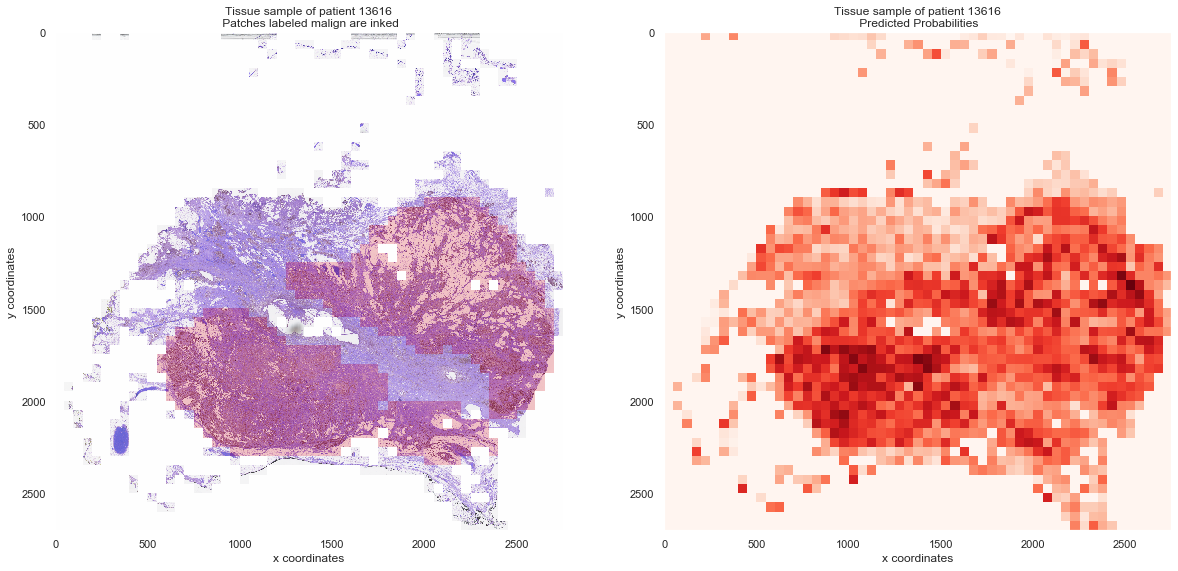

In [149]:
# visualise tissues (on the left: as diagnosed/labeled, on the right: with probabilities for being malign)
plotFullTissueWithPredictions(13616, dfWithCoords, predictions_df=df_predict_2020_1_11_22h12m11s)

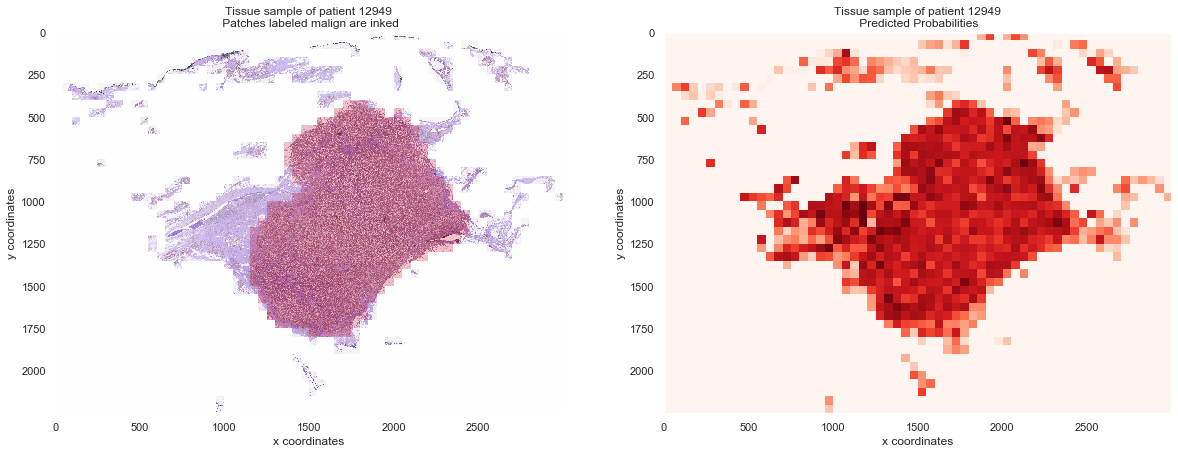

In [150]:
plotFullTissueWithPredictions(12949, dfWithCoords, predictions_df=df_predict_2020_1_11_22h12m11s)